# Business Case Study: Scaler - Clustering

## Introduction
Scaler is an online tech-versity offering intensive computer science & Data Science courses through live classes delivered by tech leaders and subject matter experts. The meticulously structured program enhances the skills of software professionals by offering a modern curriculum with exposure to the latest technologies. It is a product by InterviewBit.

You are working as a data scientist with the analytics vertical of Scaler, focused on profiling the best companies and job positions to work for from the Scaler database. You are provided with the information for a segment of learners and tasked to cluster them on the basis of their job profile, company, and other features. Ideally, these clusters should have similar characteristics.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from sklearn.impute import KNNImputer, SimpleImputer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import fcluster
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the dataset
df = pd.read_csv('scaler_clustering.csv')
df.head()

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


In [4]:
# Remove unnecessary column 'Unnamed: 0'
df.drop(columns=['Unnamed: 0'], inplace=True)

## Exploratory Data Analysis (EDA)

### 1. Dataset Structure and Basic Info

In [5]:
# Shape of the dataset
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset has 205843 rows and 6 columns.


In [6]:
# Info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   company_hash      205799 non-null  object 
 1   email_hash        205843 non-null  object 
 2   orgyear           205757 non-null  float64
 3   ctc               205843 non-null  int64  
 4   job_position      153279 non-null  object 
 5   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.4+ MB


Observation: Dataset Description
- **company_hash**: Anonymized identifier for the company (current employer)
- **email_hash**: Anonymized personal identifier
- **orgyear**: Employment start year
- **ctc**: Current CTC (salary)
- **job_position**: Job profile in the company
- **ctc_updated_year**: Year in which CTC was last updated

In [7]:
# Check for percentage of missing values in dataset
(df.isnull().mean()*100).loc[lambda x: x > 0].sort_values(ascending=False)

job_position    25.535967
orgyear          0.041779
company_hash     0.021376
dtype: float64

Observation:
- More than 25% of the job_position values are missing.
- orgyear and company_hash columns are missing values less than 1% which can be considered as negligible.

In [8]:
# Describing the dataset
df.describe(include='object').T

,count,unique,top,freq
company_hash,205799,37299,nvnv wgzohrnvzwj otqcxwto,8337
email_hash,205843,153443,bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...,10
job_position,153279,1016,Backend Engineer,43554


In [9]:
df.describe(include='number').round(0).astype(int)

,orgyear,ctc,ctc_updated_year
count,205757,205843,205843
mean,2015,2271685,2020
std,64,11800914,1
min,0,2,2015
25%,2013,530000,2019
50%,2016,950000,2020
75%,2018,1700000,2021
max,20165,1000150000,2021


Observation:
- ctc column found to be right skewed as the Mean is higher than Median
- Backend Engineer is the most frequent job_position in the dataset

In [10]:
# Value counts of categorical columns
for col in df.columns:
    unique_values = df[col].nunique()
    print(f'Unique values in {col}: {unique_values}\n')
    if unique_values < 10:
        print(f'Value counts for {col}:\n{df[col].value_counts()}\n')
    print(f'Percentage of unique values in {col}: {unique_values/df.shape[0]*100:.2f}%\n')
    print("" + "-"*50 + "\n")

Unique values in company_hash: 37299

Percentage of unique values in company_hash: 18.12%

--------------------------------------------------

Unique values in email_hash: 153443

Percentage of unique values in email_hash: 74.54%

--------------------------------------------------

Unique values in orgyear: 77

Percentage of unique values in orgyear: 0.04%

--------------------------------------------------

Unique values in ctc: 3360

Percentage of unique values in ctc: 1.63%

--------------------------------------------------

Unique values in job_position: 1016

Percentage of unique values in job_position: 0.49%

--------------------------------------------------

Unique values in ctc_updated_year: 7

Value counts for ctc_updated_year:
ctc_updated_year
2019.0    68688
2021.0    64976
2020.0    49444
2017.0     7561
2018.0     6746
2016.0     5501
2015.0     2927
Name: count, dtype: int64

Percentage of unique values in ctc_updated_year: 0.00%

---------------------------------------

Observation:
- Company Hash is having around 18% of unique values and Job Position is having around 0.5% of unique values. 
- This indicates that those values are repeated a lot in the dataset.
- On the other hand, nearly 75% of the email hashes are unique values which indicates that the users info is not repeated much.
- orgyear is having so many invalid years which needs to be processed.
- ctc_updated_year is proper and can be converted to datatime.
- There are 1016 roles available in this dataset.

In [11]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f'The dataset has {duplicates} duplicate rows.')

The dataset has 34 duplicate rows.



### 2. Data Preprocessing

In [12]:
# Remove duplicated rows
df.drop_duplicates(inplace=True)
print(f'After removing duplicates, the dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

After removing duplicates, the dataset has 205809 rows and 6 columns.


In [13]:
# Use Regex to clean company_hash column
df['company_hash'] = df['company_hash'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', str(x)))

In [14]:
# Treating orgyear column as it's containing invalid years
valid_year_range = range(1900, datetime.now().year + 1)
df['orgyear'] = df['orgyear'].apply(lambda x: x if x in valid_year_range else np.nan)

In [15]:
# Convert orgyear and ctc_updated_year columns to datetime year format
df['orgyear'] = pd.to_datetime(df['orgyear'], format='%Y', errors='coerce').dt.year
df['ctc_updated_year'] = pd.to_datetime(df['ctc_updated_year'], format='%Y', errors='coerce').dt.year

In [16]:
# check for percentage of missing values again
missing_values = df.isnull().sum() / df.shape[0] * 100
print(f'Missing values in the dataset:\n{missing_values[missing_values > 0]}')

Missing values in the dataset:
orgyear          0.077256
job_position    25.532411
dtype: float64


Observation: 
- Even after changing the invalid orgyear values, it's still low and can be considered as negligible.

In [17]:
# Impute missing values using KNNImputer for numerical columns
imputer = KNNImputer(n_neighbors=5)
df[['orgyear']] = imputer.fit_transform(df[['orgyear']])

In [18]:
# checking the unique values in job_position column
df['job_position'].value_counts()*100 / df.shape[0]

job_position
Backend Engineer                           21.158453
FullStack Engineer                         12.006764
Other                                       8.780471
Frontend Engineer                           5.061489
Engineering Leadership                      3.338046
                                             ...    
Auditing                                    0.000486
Senior software Test Engineer               0.000486
Front End Dev                               0.000486
SRE                                         0.000486
Software Development Engineering Intern     0.000486
Name: count, Length: 1016, dtype: float64

Observation: 
- Even the most frequent Job Position (Backend Engineer) is contributing to 21% in the entire dataset, imputing missing positions as "Others" will increase bias towards the dataset.

In [19]:
# Impute job_position by grouping by company_hash and ctc_updated_year
df['job_position'] = df.groupby(['company_hash', 'ctc'], observed=False)['job_position'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
df['job_position'] = df.groupby(['ctc'], observed=False)['job_position'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
df['job_position'] = df.groupby(['company_hash'], observed=False)['job_position'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)

In [20]:
# SimpleImputer for categorical columns
imputer = SimpleImputer(strategy='most_frequent')
categorical_cols = ['company_hash', 'email_hash', 'job_position']
df[categorical_cols] = imputer.fit_transform(df[categorical_cols])

In [21]:
# Check any missing values again
print(f'After imputation, the dataset has {df.isnull().sum().sum()} missing values.')

After imputation, the dataset has 0 missing values.


In [22]:
# Converting to respective data types after preprocessing
numeric_cols = ['orgyear', 'ctc_updated_year']
df[numeric_cols] = df[numeric_cols].astype('int16')
numeric_cols.append('ctc')
df['ctc'] = df['ctc'].astype('int32')
df[categorical_cols] = df[categorical_cols].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205809 entries, 0 to 205842
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   company_hash      205809 non-null  category
 1   email_hash        205809 non-null  category
 2   orgyear           205809 non-null  int16   
 3   ctc               205809 non-null  int32   
 4   job_position      205809 non-null  category
 5   ctc_updated_year  205809 non-null  int16   
dtypes: category(3), int16(2), int32(1)
memory usage: 11.6 MB


### 3. Outlier Treatment

In [23]:
# count plot for col
def plot_count(col):
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    # Count plot
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='viridis', ax=axes[0])
    axes[0].set_title(f'Count of {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=90)

    # Box plot
    sns.boxplot(data=df, x=col, palette='viridis', ax=axes[1])
    axes[1].set_title(f'Boxplot of {col}')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Value')
    axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

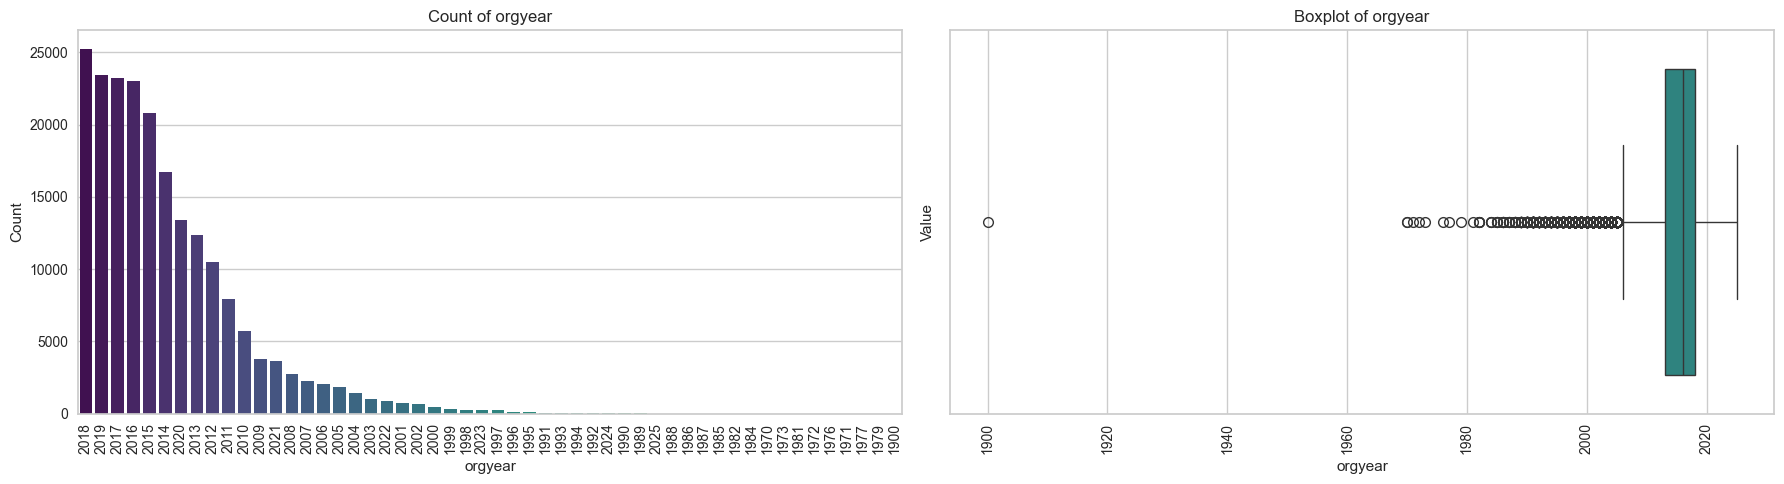

In [24]:
plot_count('orgyear')

Observation:
- Since all the orgyears which are invalid were imputed already, we left with the data starting from 1900 till 2018.
- Will find the 1 and 99 percentile and will clip it.

In [25]:
print(f'0.1 percentile of orgyear: {df["orgyear"].quantile(0.001)} and 99.9 percentile: {df["orgyear"].quantile(0.999)}')

0.1 percentile of orgyear: 1992.0 and 99.9 percentile: 2023.0


In [26]:
# Clip the orgyear values to remove outliers ignoring the upper limit
df['orgyear'] = df['orgyear'].clip(lower=df['orgyear'].quantile(0.001), upper=df['orgyear'].quantile(0.999), axis=0)

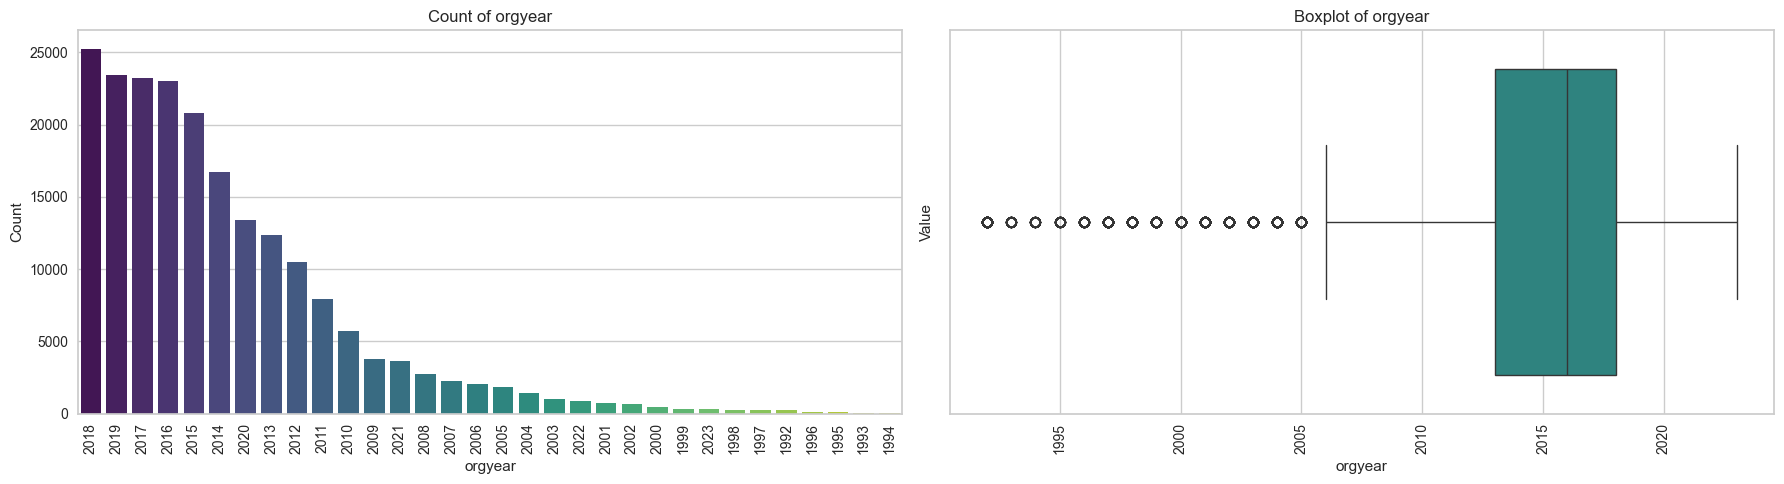

In [27]:
plot_count('orgyear')

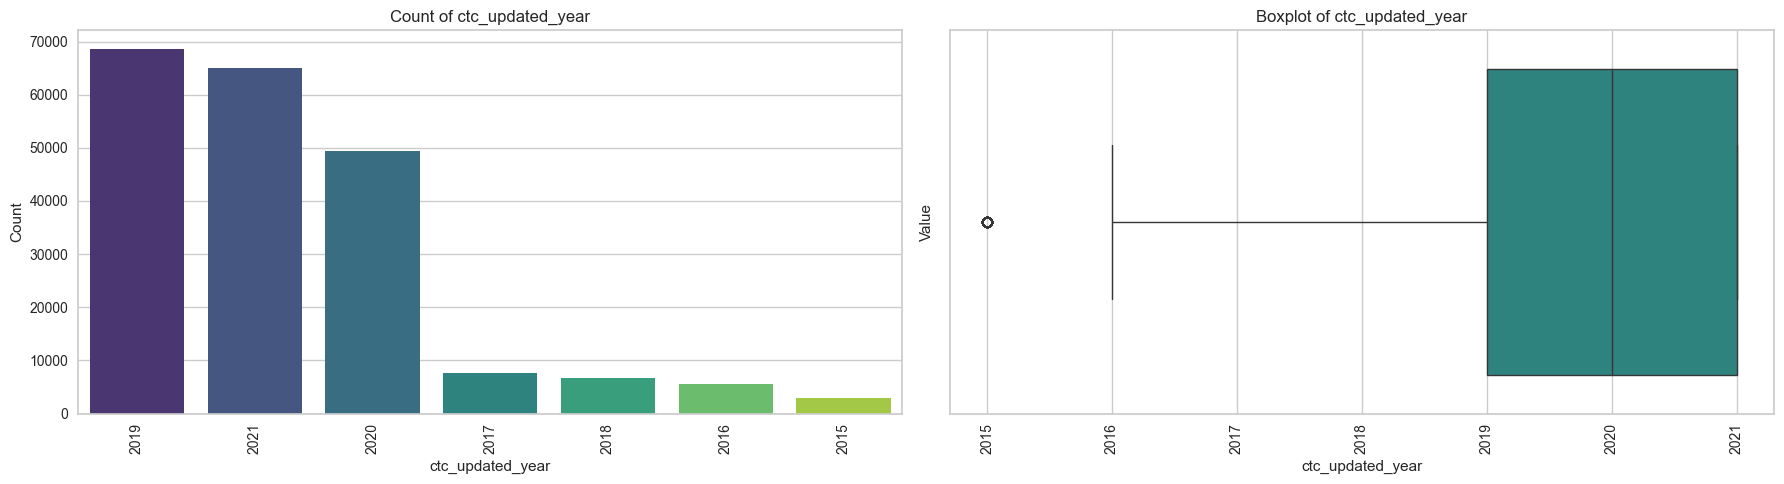

In [28]:
plot_count('ctc_updated_year')

In [29]:
# Same for ctc_updated_year
print(f'0.1 percentile of ctc_updated_year: {df["ctc_updated_year"].quantile(0.001)} and 99.9 percentile: {df["ctc_updated_year"].quantile(0.999)}')
# Clip the ctc_updated_year values to remove outliers ignoring the upper limit
df['ctc_updated_year'] = df['ctc_updated_year'].clip(lower=df['ctc_updated_year'].quantile(0.001), upper=df['ctc_updated_year'].quantile(0.999), axis=0)

0.1 percentile of ctc_updated_year: 2015.0 and 99.9 percentile: 2021.0


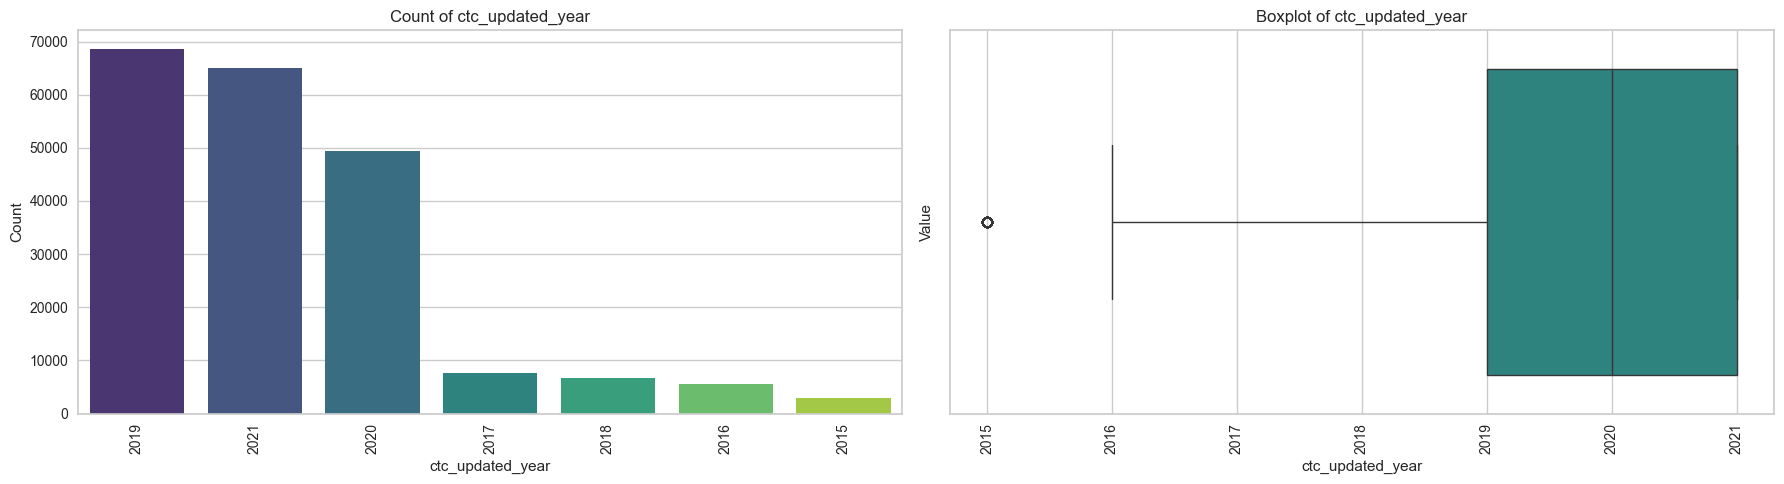

In [30]:
plot_count('ctc_updated_year')

In [31]:
# Same for ctc
print(f'0.1 percentile of ctc: {df["ctc"].quantile(0.001)} and 99.9 percentile: {df["ctc"].quantile(0.999)}')
# Remove outliers in ctc column
df = df.loc[((df.ctc) > df.ctc.quantile(0.01)) & ((df.ctc) < df.ctc.quantile(0.99))]


0.1 percentile of ctc: 3500.0 and 99.9 percentile: 200000000.0


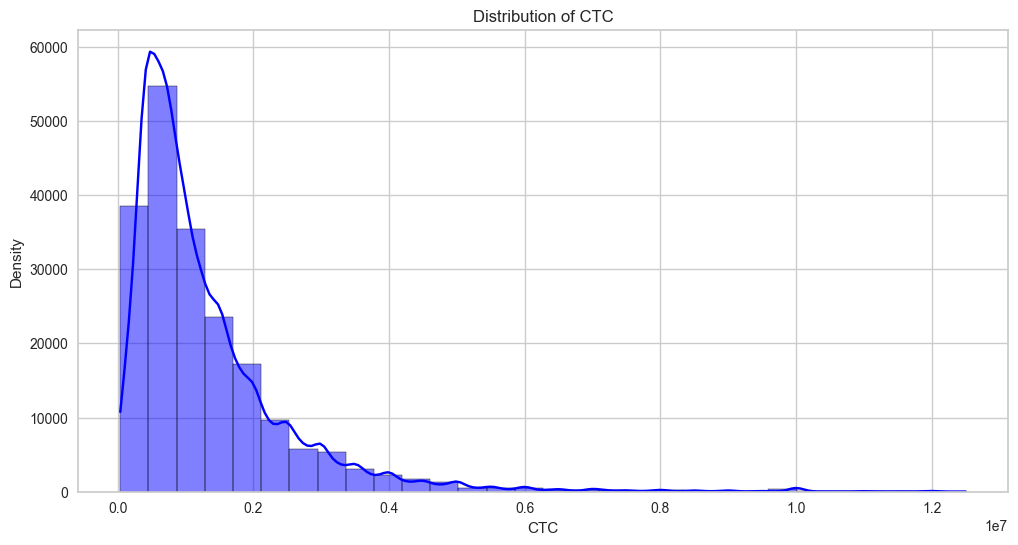

In [32]:
# Dist plot for ctc
plt.figure(figsize=(12, 6))
sns.histplot(df['ctc'], kde=True, bins=30, color='blue')
plt.title('Distribution of CTC')
plt.xlabel('CTC')
plt.ylabel('Density')
plt.show()

In [33]:
# Remove rows with invalid company_hash
df = df[df["company_hash"]!="nan"]

In [34]:
# Check for percentage of company_hash with less than 5 records
df[df.groupby("company_hash")["ctc"].transform("count") < 5].shape[0] / df.shape[0] * 100

23.088558378504374

Observation:
- Since, so many companies were occured only less than 5 times, will group them into separate category
- This contributes to 23% of total datapoints

In [35]:
# Mask for company_hash with less than 5 records
mask = df.groupby("company_hash")["ctc"].transform("count") < 5
# Add 'less_occurred' to the categories if not present
if "less_occurred" not in df["company_hash"].cat.categories:
	df["company_hash"] = df["company_hash"].cat.add_categories(["less_occurred"])
# Replace company_hash with 'less_occurred' for those records
df.loc[mask, "company_hash"] = "less_occurred"

In [36]:
df.sample(5)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
94205,less_occurred,7bddf04b4aa78319de32846ef37a33b55fc6cd839b2d64...,2008,1200000,Junior developer,2021
191394,less_occurred,49d8480e68d6755e2b46ac16de3d26cfd38e1a615da68f...,2008,640000,QA Engineer,2019
186301,vbvkgz,debcf7ab83d26b4b8ce1981d20235eb3fb2f4617dd2820...,2012,6580000,FullStack Engineer,2019
187115,wxowg,26c42650bbd15a78272b357be2a709115b89186c53f0b3...,2004,3200000,Other,2018
127581,qmo xzaxv,72cf166f2d9d2c95fe5ff6e78145ce8e4fb1fa32f86be7...,2019,600000,Devops Engineer,2021


In [37]:
# Create a new column 'Year Of Experience' based on current year and orgyear
df['year_of_exp'] = datetime.now().year - df['orgyear']

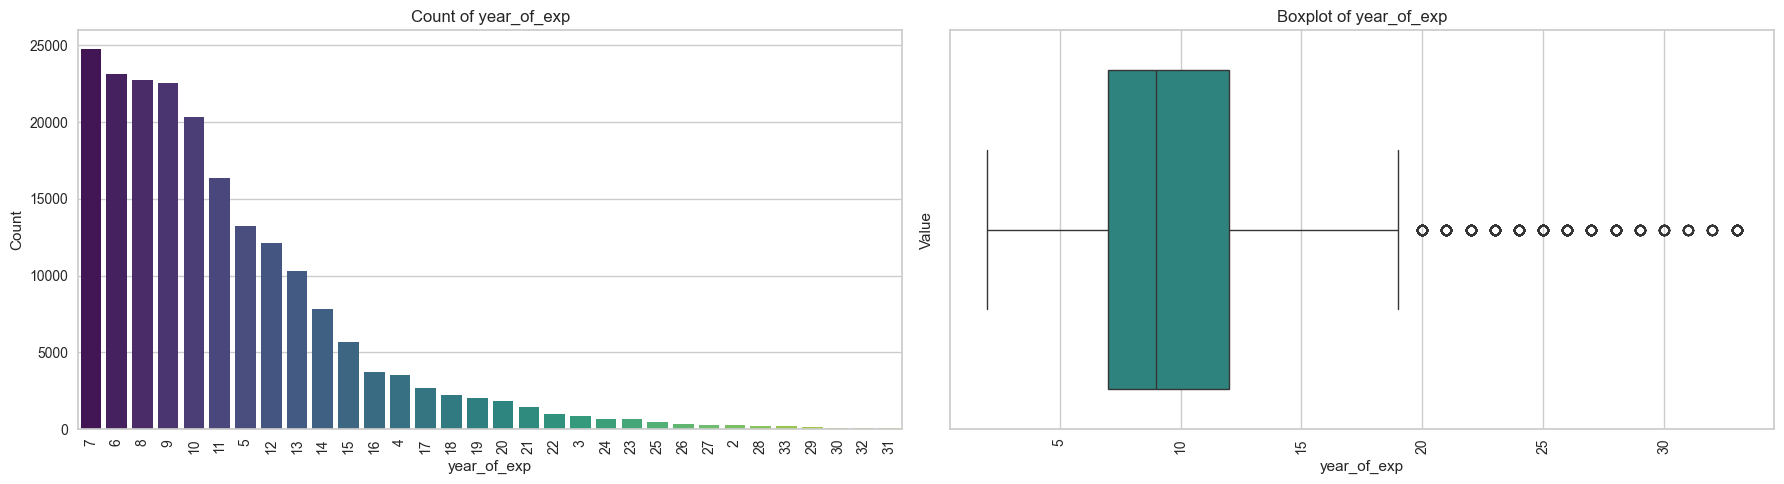

In [38]:
plot_count('year_of_exp')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201641 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   company_hash      201641 non-null  category
 1   email_hash        201641 non-null  category
 2   orgyear           201641 non-null  int16   
 3   ctc               201641 non-null  int32   
 4   job_position      201641 non-null  category
 5   ctc_updated_year  201641 non-null  int16   
 6   year_of_exp       201641 non-null  int16   
dtypes: category(3), int16(3), int32(1)
memory usage: 11.9 MB


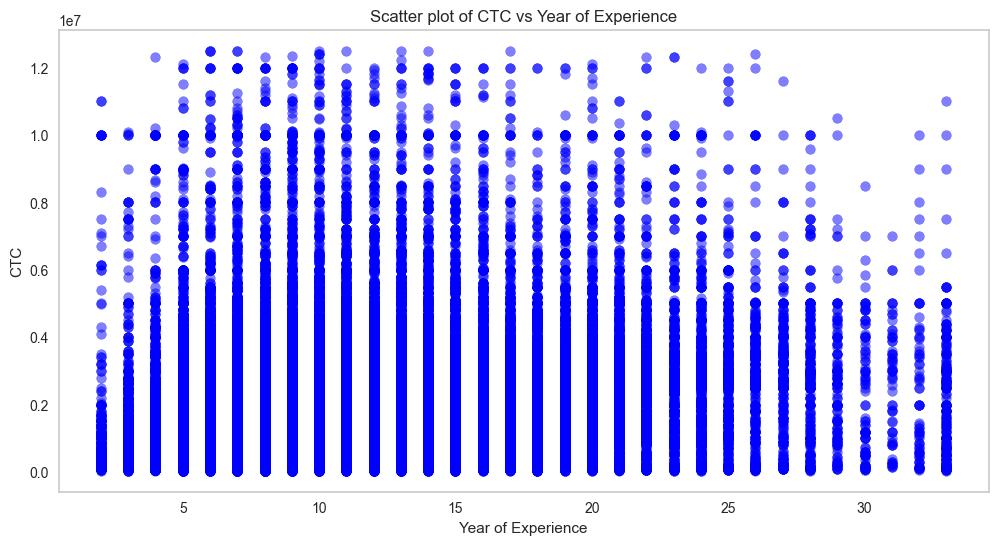

In [40]:
# scatter plot for ctc and year_of_exp
plt.figure(figsize=(12, 6))
plt.scatter(df['year_of_exp'], df['ctc'], alpha=0.5, color='blue')
plt.title('Scatter plot of CTC vs Year of Experience')
plt.xlabel('Year of Experience')
plt.ylabel('CTC')
plt.grid()
plt.show()

## Manual Clustering

### 1. Clustering based on Year of Experience, Job Position and Company Hash

In [41]:
grouped_ctc = df.groupby(["year_of_exp", "job_position", "company_hash"])["ctc"].describe() 

In [42]:
grouped_ctc.head()

count          mean  \
year_of_exp job_position      company_hash                                  
2           Android Engineer  yxpt btootzstq            1.0  3.000000e+05   
                              zgn vuurxwvmrt vwwghzn    3.0  4.253333e+06   
            Backend Architect zvz                       1.0  1.500000e+05   
            Backend Engineer  zgn vuurxwvmrt vwwghzn    3.0  2.462000e+06   
                              zvz                       4.0  2.050000e+06   

                                                               std        min  \
year_of_exp job_position      company_hash                                      
2           Android Engineer  yxpt btootzstq                   NaN   300000.0   
                              zgn vuurxwvmrt vwwghzn  3.250482e+06   500000.0   
            Backend Architect zvz                              NaN   150000.0   
            Backend Engineer  zgn vuurxwvmrt vwwghzn  3.227670e+06    56000.0   
                              zvz                     1.021437e+06  1200000.0   

                                                            25%        50%  \
year_of_exp job_position      company_hash                                   
2           Android Engineer  yxpt btootzstq           300000.0   300000.0   
                              zgn vuurxwvmrt vwwghzn  3315000.0  6130000.0   
            Backend Architect zvz                      150000.0   150000.0   
            Backend Engineer  zgn vuurxwvmrt vwwghzn   628000.0  1200000.0   
                              zvz                     1425000.0  1750000.0   

                                                            75%        max  
year_of_exp job_position      company_hash                                  
2           Android Engineer  yxpt btootzstq           300000.0   300000.0  
                              zgn vuurxwvmrt vwwghzn  6130000.0  6130000.0  
            Backend Architect zvz                      150000.0   150000.0  
            Backend Engineer  zgn vuurxwvmrt vwwghzn  3665000.0  6130000.0  
                              zvz                     2375000.0  3500000.0

In [43]:
df_grouped_yoe_jp_ch = df.merge(grouped_ctc, on=["year_of_exp", "job_position", "company_hash"], how="left")

In [44]:
df_grouped_yoe_jp_ch.sample(5)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,count,mean,std,min,25%,50%,75%,max
1003,bvi ogenfvqt,fcb6332a636530948581ca817fabfb0ceed7afb835e66f...,2017,980000,FullStack Engineer,2020,8,6.0,7.883333e+05,3.175164e+05,250000.0,725000.0,800000.0,935000.0,1200000.0
93791,less_occurred,328a91cff446a159c91b94893c7728e6521455bc61d560...,2016,500000,Backend Engineer,2021,9,1455.0,1.116303e+06,1.244224e+06,40000.0,495000.0,800000.0,1300000.0,12000000.0
166953,xzegojo,e5ebf48289fcb710870a0abf1d0c61713699551cf52a55...,2018,390000,Backend Engineer,2020,7,199.0,5.951608e+05,3.571912e+05,200000.0,400000.0,480000.0,780000.0,4000000.0
129111,tdr,831edf4ee86369862515dc7102cce5aab1d544d60ab959...,2018,600000,Data Analyst,2019,7,7.0,7.135714e+05,3.682019e+05,325000.0,580000.0,600000.0,715000.0,1480000.0
134492,less_occurred,669b43271ac1a14ccd2110117753c3359a6f9a0e28cfcd...,2015,650000,SDET,2019,10,224.0,7.736160e+05,8.344246e+05,180000.0,550000.0,650000.0,782500.0,10500000.0


In [45]:
def classification_ctc(row): 
    if row['ctc'] > row['mean']:
        return 3
    elif row['ctc'] == row['mean']:
        return 2
    else:
        return 1

In [46]:
df_grouped_yoe_jp_ch['designation'] = df_grouped_yoe_jp_ch.apply(classification_ctc, axis=1)

In [47]:
df_grouped_yoe_jp_ch.sample(5)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,count,mean,std,min,25%,50%,75%,max,designation
81647,less_occurred,ad23fe3e5e5246777803a1c80ac90fc56ade211e49ed75...,2010,6000000,Engineering Leadership,2020,15,162.0,2.170185e+06,1.437893e+06,40000.0,1460000.0,1950000.0,2700000.0,8100000.0,3
95108,less_occurred,326b9962408761cf363ebc8de3f7a5f6927650571001f1...,2017,1200000,Fullstack Engineer,2020,8,52.0,8.263461e+05,2.882539e+05,400000.0,600000.0,740000.0,1000000.0,1700000.0,3
49973,bgmxrtxqgz,ff4036587f9d7fe56415a21c6ce886baa6b772c6b0b1fc...,2008,3300000,SDET,2018,17,2.0,2.900000e+06,5.656854e+05,2500000.0,2700000.0,2900000.0,3100000.0,3300000.0,3
172255,onvqn hu,c4931db9b36f634b43cafa93492a86e70964b6bef51423...,2016,3300000,Backend Engineer,2020,9,1.0,3.300000e+06,NaN,3300000.0,3300000.0,3300000.0,3300000.0,3300000.0,2
27600,fxuqg rxbxnta,89d26a5383944dd425632ad00ec07bc6127fe70b7c9ae6...,2020,360000,Other,2021,5,88.0,4.740113e+05,3.206902e+05,100000.0,350000.0,350000.0,650000.0,2200000.0,1


In [48]:
df_grouped_yoe_jp_ch['designation'].value_counts(normalize=True)

designation
1    0.461781
3    0.302825
2    0.235394
Name: proportion, dtype: float64

Observation:
- Most of the designmation falls under mean ctc which contributes around 46%
- Around 23% were having the mean ctc 
- Only around 30% is having higher than mean ctc

In [49]:
# drop unnecessary columns
df_grouped_yoe_jp_ch.drop(columns=['count','mean', 'std', 'min', '25%', '50%', '75%', 'max'], inplace=True)

In [50]:
df_grouped_yoe_jp_ch.sample(5)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,designation
131021,zgn vuurxwvmrt vwwghzn,c9b27da8d6f37bfef3028aa8b8ade02e34863df52ef1ca...,2020,1000000,Backend Engineer,2021,5,3
14076,ytfrtnn uvwpvqa tzntquqxot,f6e7bb3c5396b585be2b73ef57e9535e2749deba3a95ef...,2016,600000,Backend Engineer,2021,9,1
68841,fxuqg rxbxnta,96d899fe52cd6018a1ed8af0efeb6a879c595bcf53b61d...,2010,1400000,Devops Engineer,2018,15,2
53609,q ojontbo xzntqzvnxgzvr,6c267aaa25aff1441782e293f7e8218b83ab9033779dec...,2007,1600000,Engineering Leadership,2019,18,2
96838,eqtoytq,4c1176300b16cf537c120203914425485ba8ec2bba0c6a...,2020,800000,Other,2019,5,1


### 2. Clustering based on Company and Job Position

In [51]:
grouped_jp_ch = df.groupby(["job_position", "company_hash"])["ctc"].describe()
grouped_jp_ch.head()

,,count,mean,std,min,25%,50%,75%,max
job_position,company_hash,,,,,,,,
SDE 2,bvptbjnqxuwgb,1.0,1200000.0,NaN,1200000.0,1200000.0,1200000.0,1200000.0,1200000.0
.,less_occurred,1.0,700000.0,NaN,700000.0,700000.0,700000.0,700000.0,700000.0
..,otre tburgjta,1.0,600000.0,NaN,600000.0,600000.0,600000.0,600000.0,600000.0
.7,wgszxkvzn,1.0,470000.0,NaN,470000.0,470000.0,470000.0,470000.0,470000.0
7,less_occurred,1.0,420000.0,NaN,420000.0,420000.0,420000.0,420000.0,420000.0


In [52]:
df_grouped_jp_ch = df.merge(grouped_jp_ch, on=["job_position", "company_hash"], how="left")
df_grouped_jp_ch.sample(5)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,count,mean,std,min,25%,50%,75%,max
157611,stzuvwn,bda94abff79f7045cc553da9a39fb9fc993e23082b2a0a...,2017,500000,Data Scientist,2019,8,22.0,1.317727e+06,607515.877262,500000.0,790000.0,1330000.0,1700000.0,2460000.0
111032,znn avnv otqcxwto,40c03c0099fc8b42d6f5c4674b7dc7389ab86781abe07a...,2018,500000,Frontend Engineer,2021,7,22.0,7.156364e+05,355577.805491,350000.0,447500.0,620000.0,837500.0,1550000.0
182314,vqxwtzn,00eab22b285848b49c08d80726f447721ebbbe01658965...,2011,3450000,Backend Architect,2019,14,1.0,3.450000e+06,NaN,3450000.0,3450000.0,3450000.0,3450000.0,3450000.0
188388,tcgrtzn ytvrny,c8ca2e4c14ccadb85a8fc076e784fd33e81f5dcd53b392...,2013,1800000,Frontend Engineer,2019,12,2.0,1.525000e+06,388908.729653,1250000.0,1387500.0,1525000.0,1662500.0,1800000.0
50242,ztdnstz ytvrnywvqt,d83d000532bf6ddf22f1526ddf73d5803d24719920368c...,2017,1630000,FullStack Engineer,2020,8,10.0,9.480000e+05,297650.055528,650000.0,800000.0,800000.0,1050000.0,1630000.0


In [53]:
df_grouped_jp_ch['class'] = df_grouped_jp_ch.apply(classification_ctc, axis=1)
df_grouped_jp_ch.sample(5)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,count,mean,std,min,25%,50%,75%,max,class
25465,hzxojo xzaxv,005ba99ef7fa4118caa0e34c0e4d68cc671699f58eac35...,2016,1010000,Other,2019,9,10.0,9.160000e+05,4.304829e+05,320000.0,800000.0,810000.0,985000.0,2000000.0,3
59845,wxnx,8266ef332ef54cf9677e938c31cb44152beab56f713701...,2004,1900000,Backend Engineer,2017,21,160.0,1.852631e+06,6.748720e+05,85000.0,1430000.0,1670000.0,2100000.0,5000000.0,3
14686,wgszxkvzn,00ba988a37686adc250c4316904d6603f116ee4f423932...,2014,1200000,Security Leadership,2021,11,1.0,1.200000e+06,NaN,1200000.0,1200000.0,1200000.0,1200000.0,1200000.0,2
20944,ehnhqt sqghu xzaxv,32912eba013c51daf6a10d2c3148afaa8a460b7c377bbf...,2016,480000,Other,2020,9,4.0,1.165000e+06,1.227721e+06,480000.0,480000.0,590000.0,1275000.0,3000000.0,1
175616,less_occurred,f893a1b4a4c5be1312cb1a01f01c645cb7a4394bc3fc85...,2005,2160000,Android Engineer,2019,20,2853.0,8.978896e+05,7.759140e+05,40000.0,500000.0,720000.0,1019999.0,10000000.0,3


In [54]:
df_grouped_jp_ch['class'].value_counts(normalize=True)

class
1    0.577898
3    0.353698
2    0.068404
Name: proportion, dtype: float64

Observation:
- Over 57% of the data fell under mean ctc
- Only less than 1% of the data were having the same ctc
- Over 35% of data were having more the mean ctc

In [55]:
# Remove unnecessary columns
df_grouped_jp_ch.drop(columns=['count','mean', 'std', 'min', '25%', '50%', '75%', 'max'], inplace=True)
df_grouped_jp_ch.sample(5)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,class
34660,tqxwoogz,0f12db95287402c9860d4db16b445859bac9ac4c62e62c...,2015,400000,Non Coder,2021,10,1
30109,erxupvqn,7fab7be0b50c3d39ffd642552cd4be78bbfd91741a4acb...,2017,700000,Other,2021,8,1
172399,vwwtznhqt,8c74659276d48efa7e4d0a6912b12def83fc804655459b...,2012,130000,FullStack Engineer,2018,13,1
39375,less_occurred,a879de3dd54d6ac3dbc886f0b92e5685f8f710fb1ba9aa...,2015,300000,Other,2021,10,1
41812,ogwxtnt stztqvrt srgmvr ogrhnxgz wtznqt,42008cc0a5501259a93f1a253de30b7d38287915a5af51...,2016,1370000,FullStack Engineer,2020,9,1


In [56]:
df_grouped_yoe_jp_ch.sample(5)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,designation
83167,mggpxzswgb,0db83e551220cdaa91b4b4de742b1b4d568b8c34b13994...,2014,8400000,Backend Engineer,2020,11,3
57637,less_occurred,e97e04761c82a8c59c0a1da4fe414e27dd25d9894158bd...,2015,690000,Other,2021,10,1
178680,zgzt vn nyt bgbtzn,6a128680d3b7242f61dc7702fc218e2c0e184d21c79490...,2017,400000,Frontend Engineer,2019,8,2
146207,vouxqt ojontbo,8bff9cd1fb870e34f692e1ae0204a77d48504b8990be26...,2013,450000,QA Engineer,2019,12,1
51526,oyguwrhto,e8bc12a4f0a08565620a705861b7902e39dc867aa92e3d...,2014,950000,Backend Engineer,2017,11,1


In [57]:
# Merge the two dataframes
df_final = df_grouped_yoe_jp_ch.merge(df_grouped_jp_ch, on=['email_hash','company_hash', 'orgyear', 'ctc', 'job_position', 'year_of_exp', 'ctc_updated_year'], how="left")
df_final.sample(5)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,designation,class
2658,wsx xzegqbvnxgz ojontb vza bvzvstbtzn wgzohrnvzn,b49c5715ee4438555f047479395386d20f6ff960f3926d...,2016,700000,Support Engineer,2020,9,3,3
32581,otre tburgjta,8fff741abf56c1b285dc072da7d1fa775c05214b2c11a3...,2012,3000000,Other,2020,13,3,3
172343,vqwtoxhb,a9029bae09811b3ea7aa4a8fbf44047d8dab1139b5fafd...,2015,2200000,FullStack Engineer,2019,10,1,3
131908,fxuqg rxbxnta,c155e6e7f0bc598526e92cade662cf468c2595aa93c1b9...,2018,5000000,Backend Engineer,2021,7,3,3
105425,less_occurred,2a6cf29a969b589741d58141ba89ce47208cdd8f9853b0...,2014,90000,Data Analyst,2017,11,1,1


### 3. Manual Classification by Company

In [58]:
grouped_cmpny = df.groupby(["company_hash"])["ctc"].describe()

In [59]:
grouped_cmpny.sample(5)

,count,mean,std,min,25%,50%,75%,max
company_hash,,,,,,,,
ztndwtrr rxbxnta,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xzzgctwnhqt,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bjxzaxvzonvj,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oqx ovqvav wgrrtst egq fgbtz nxqhztrctrx,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ygnovq,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
df_grouped_cmpny = df.merge(grouped_cmpny, on=["company_hash"], how="left")
df_grouped_cmpny.sample(5)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,count,mean,std,min,25%,50%,75%,max
173881,ohnytqrvza srgmvr otqcxwto,912e8e08e2649d3f59942100d992799144164b0990dce9...,2010,1300000,SDET,2019,15,26.0,1.163846e+06,9.372218e+05,200000.0,500000.0,975000.0,1385000.0,4300000.0
84688,gutzntdn xzw,6eec69d1a296d29e9db525d144bbeea60f934987e5f621...,2014,1300000,FullStack Engineer,2020,11,11.0,1.135455e+06,3.649483e+05,180000.0,1050000.0,1130000.0,1340000.0,1500000.0
20726,zgzt,7e32325f0858cdebf52b63bc549d62983c7a9a93dbd32e...,2021,200000,Other,2020,4,629.0,1.091999e+06,1.433676e+06,39000.0,310000.0,660000.0,1300000.0,11000000.0
161828,kxrrxgho ogrhnxgzo,f3709c4b631a8ed183c7c40ec391a53f0bc16a84a577b3...,2018,1430000,Backend Engineer,2019,7,23.0,1.182957e+06,3.639275e+05,600000.0,980000.0,1100000.0,1415000.0,1900000.0
42952,nvcvzn,a62c92a66085f9277970c47e0aebdc3aefad2c14259c74...,2015,900000,Frontend Engineer,2021,10,175.0,1.081709e+06,1.033179e+06,75000.0,590000.0,890000.0,1055000.0,10000000.0


In [61]:
df_grouped_cmpny['tier'] = df_grouped_cmpny.apply(classification_ctc, axis=1)

In [62]:
df_grouped_cmpny['tier'].value_counts(normalize=True)

tier
1    0.640772
3    0.358801
2    0.000427
Name: proportion, dtype: float64

Observation:
- Over 64% of the data lies under mean ctc
- Over 35% of the data lies above mean ctc
- only neglible (less than 1%) of data have the mean ctc

In [63]:
# Drop unnecessary columns
df_grouped_cmpny.drop(columns=['count','mean', 'std', 'min', '25%', '50%', '75%', 'max'], inplace=True)

In [64]:
df_grouped_cmpny.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,tier
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,9,1
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018,449999,FullStack Engineer,2019,7,1
2,less_occurred,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015,2000000,Backend Engineer,2020,10,3
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017,700000,Backend Engineer,2019,8,1
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017,1400000,FullStack Engineer,2019,8,3


In [65]:
df_final = df_final.merge(df_grouped_cmpny, on=['email_hash','company_hash', 'orgyear', 'ctc', 'job_position', 'year_of_exp', 'ctc_updated_year'], how="left")
df_final.sample(5)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,designation,class,tier
83498,ntwy bvyxzaqv,dd16e34857cc5d1d1863c73fe35a7a9e5caec9eb9ebe9a...,2016,1000000,Other,2020,9,3,3,3
197877,less_occurred,550d34f2b99deced71f6a3d758b77fd4de642ecb58f0e3...,2018,1200000,Data Scientist,2021,7,3,1,3
223492,wsx,bf70bc83beeaefda9702c8bb4372a7275f9c8aa0918d00...,2017,1027999,FullStack Engineer,2021,8,3,3,3
309403,less_occurred,82192025066bc25d89c1091bfb59c8542c87639a7716b3...,2016,1300000,Backend Engineer,2019,9,3,3,3
76939,wgszxkvzn,e61d71753ff9b6d5bc3cccda97b209477830173dd423fe...,2011,600000,Backend Engineer,2021,14,1,1,1


Question 1:
- Top 10 employees (earning more than most of the employees in the company) - Tier 1
- Top 10 employees of data science in each company earning more than their peers - Class 1
- Bottom 10 employees of data science in each company earning less than their peers - Class 3
- Bottom 10 employees (earning less than most of the employees in the company)- Tier 3
- Top 10 employees in each company - X department - having 5/6/7 years of experience earning more than their peers - Tier X
- Top 10 companies (based on their CTC)
- Top 2 positions in every company (based on their CTC)

In [66]:
# Top 10 employees in each company in tier 3
top_emp_tier_3 = df_final[df_final['tier'] == 3]
top_emp_tier_3['rank'] = top_emp_tier_3.groupby('company_hash')['ctc'].rank(method='first', ascending=False)
top_emp_tier_3 = top_emp_tier_3[top_emp_tier_3['rank'] <= 10]
top_emp_tier_3.head(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,designation,class,tier,rank
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017,1400000,FullStack Engineer,2019,8,2,3,3,1.0
21,bgsrxd,3b99c28818530737364245236fba9a821187fc38cd6445...,2012,2030000,Backend Engineer,2019,13,2,3,3,2.0
22,bgsrxd,3b99c28818530737364245236fba9a821187fc38cd6445...,2012,2030000,Backend Engineer,2019,13,2,3,3,3.0
23,bgsrxd,3b99c28818530737364245236fba9a821187fc38cd6445...,2012,2030000,Backend Engineer,2019,13,2,3,3,4.0
24,bgsrxd,3b99c28818530737364245236fba9a821187fc38cd6445...,2012,2030000,Backend Engineer,2019,13,2,3,3,5.0
37,nxbto xzntqztn,d2668cb959e5657c3881413257b9850caa1359c7ce959a...,2015,9500000,Backend Engineer,2019,10,3,3,3,1.0
50,gvnx,7ed9dad40408750d848b8c1e568746be7ac2947ec098e6...,2013,780000,Frontend Engineer,2021,12,2,3,3,2.0
51,gvnx,7ed9dad40408750d848b8c1e568746be7ac2947ec098e6...,2013,780000,Frontend Engineer,2021,12,2,3,3,3.0
52,gvnx,7ed9dad40408750d848b8c1e568746be7ac2947ec098e6...,2013,780000,Frontend Engineer,2021,12,2,3,3,4.0
53,gvnx,7ed9dad40408750d848b8c1e568746be7ac2947ec098e6...,2013,780000,Frontend Engineer,2021,12,2,3,3,5.0


In [67]:
# Top 10 employees of data science in each company earning more than their peers - Class 3
top_emp_class_3 = df_final[df_final['class'] == 3]
top_emp_class_3['rank'] = top_emp_class_3.groupby('company_hash')['ctc'].rank(method='first', ascending=False)
top_emp_class_3 = top_emp_class_3[top_emp_class_3['rank'] <= 10]
top_emp_class_3.head(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,designation,class,tier,rank
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,9,2,3,1,1.0
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017,1400000,FullStack Engineer,2019,8,2,3,3,1.0
21,bgsrxd,3b99c28818530737364245236fba9a821187fc38cd6445...,2012,2030000,Backend Engineer,2019,13,2,3,3,2.0
22,bgsrxd,3b99c28818530737364245236fba9a821187fc38cd6445...,2012,2030000,Backend Engineer,2019,13,2,3,3,3.0
23,bgsrxd,3b99c28818530737364245236fba9a821187fc38cd6445...,2012,2030000,Backend Engineer,2019,13,2,3,3,4.0
24,bgsrxd,3b99c28818530737364245236fba9a821187fc38cd6445...,2012,2030000,Backend Engineer,2019,13,2,3,3,5.0
37,nxbto xzntqztn,d2668cb959e5657c3881413257b9850caa1359c7ce959a...,2015,9500000,Backend Engineer,2019,10,3,3,3,1.0
50,gvnx,7ed9dad40408750d848b8c1e568746be7ac2947ec098e6...,2013,780000,Frontend Engineer,2021,12,2,3,3,1.0
51,gvnx,7ed9dad40408750d848b8c1e568746be7ac2947ec098e6...,2013,780000,Frontend Engineer,2021,12,2,3,3,2.0
52,gvnx,7ed9dad40408750d848b8c1e568746be7ac2947ec098e6...,2013,780000,Frontend Engineer,2021,12,2,3,3,3.0


In [68]:
# Bottom 10 employees of data science in each company earning less than their peers - Class 1
bot_emp_class_1 = df_final[df_final['class'] == 1]
bot_emp_class_1['rank'] = bot_emp_class_1.groupby('company_hash')['ctc'].rank(method='first', ascending=True)
bot_emp_class_1 = bot_emp_class_1[bot_emp_class_1['rank'] <= 10]
bot_emp_class_1.head(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,designation,class,tier,rank
7,vwwtznhqt ntwyzgrgsj,756d35a7f6bb8ffeaffc8fcca9ddbb78e7450fa0de2be0...,2019,400000,Backend Engineer,2019,6,1,1,1,1.0
27,mvlvl exzotqc,62d2e04b44c8bf2f6ec15d5b4c259c06199f598dc51816...,2018,100000,Other,2021,7,2,1,1,1.0
28,mvlvl exzotqc,62d2e04b44c8bf2f6ec15d5b4c259c06199f598dc51816...,2018,100000,Other,2021,7,2,1,1,2.0
29,mvlvl exzotqc,62d2e04b44c8bf2f6ec15d5b4c259c06199f598dc51816...,2018,100000,Other,2021,7,2,1,1,3.0
30,mvlvl exzotqc,62d2e04b44c8bf2f6ec15d5b4c259c06199f598dc51816...,2018,100000,Other,2021,7,2,1,1,4.0
32,pqgzgo xzwgqugqvnta,b7d0b9cd894ab871c547063df449d03e4138050c0463c6...,2003,600000,QA Engineer,2021,22,1,1,1,2.0
36,ntdvo xzonqhbtzno,85f42e6cf6ef712c9944f27d9fa607eb8c8376589400bb...,2017,900000,Backend Engineer,2021,8,1,1,1,3.0
41,vkwgb ntwyzgrgsj,f83757429132b93fd3bdceeadc0e52b52de6a78e414f5f...,2019,650000,Backend Engineer,2019,6,2,1,1,1.0
42,vkwgb ntwyzgrgsj,f83757429132b93fd3bdceeadc0e52b52de6a78e414f5f...,2019,650000,Backend Engineer,2019,6,2,1,1,2.0
43,vkwgb ntwyzgrgsj,f83757429132b93fd3bdceeadc0e52b52de6a78e414f5f...,2019,650000,Backend Engineer,2019,6,2,1,1,3.0


In [69]:
# Bottom 10 employees (earning less than most of the employees in the company)- Tier 1
bot_emp_tier_1 = df_final[df_final['tier'] == 1]
bot_emp_tier_1['rank'] = bot_emp_tier_1.groupby('company_hash')['ctc'].rank(method='first', ascending=True)
bot_emp_tier_1 = bot_emp_tier_1[bot_emp_tier_1['rank'] <= 10]
bot_emp_tier_1.head(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,designation,class,tier,rank
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,9,2,3,1,6.0
5,yvuuxrj hzbvqqxta bvqptnxzs ucn rna,18f2c4aa2ac9dd3ae8ff74f32d30413f5165565b90d8f2...,2018,700000,FullStack Engineer,2020,7,2,2,1,3.0
7,vwwtznhqt ntwyzgrgsj,756d35a7f6bb8ffeaffc8fcca9ddbb78e7450fa0de2be0...,2019,400000,Backend Engineer,2019,6,1,1,1,3.0
27,mvlvl exzotqc,62d2e04b44c8bf2f6ec15d5b4c259c06199f598dc51816...,2018,100000,Other,2021,7,2,1,1,1.0
28,mvlvl exzotqc,62d2e04b44c8bf2f6ec15d5b4c259c06199f598dc51816...,2018,100000,Other,2021,7,2,1,1,2.0
29,mvlvl exzotqc,62d2e04b44c8bf2f6ec15d5b4c259c06199f598dc51816...,2018,100000,Other,2021,7,2,1,1,3.0
30,mvlvl exzotqc,62d2e04b44c8bf2f6ec15d5b4c259c06199f598dc51816...,2018,100000,Other,2021,7,2,1,1,4.0
32,pqgzgo xzwgqugqvnta,b7d0b9cd894ab871c547063df449d03e4138050c0463c6...,2003,600000,QA Engineer,2021,22,1,1,1,2.0
36,ntdvo xzonqhbtzno,85f42e6cf6ef712c9944f27d9fa607eb8c8376589400bb...,2017,900000,Backend Engineer,2021,8,1,1,1,4.0
38,nyvuvq hzxctqoxnj,9193cad13d506216fea5f0f920f16bc110a82c3d3cf52e...,2020,600000,Engineering Intern,2021,5,2,2,1,1.0


In [70]:
# Top 10 employees in each company - X department - having 5/6/7 years of experience earning more than their peers - Tier X
top_experienced_emp = df_final[df_final['tier'] == 3]
top_experienced_emp = top_experienced_emp[(top_experienced_emp['year_of_exp'] >= 5) & (top_experienced_emp['year_of_exp'] <= 7)]
top_experienced_emp['rank'] = top_experienced_emp.groupby(['company_hash', 'job_position'])['ctc'].rank(method='first', ascending=False)
top_experienced_emp = top_experienced_emp[top_experienced_emp['rank'] <= 10]
top_experienced_emp.head(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,designation,class,tier,rank
26,puxn,26b502eb6439ac80bd618a6f7c2b1c640b84c1e64c472c...,2020,1400000,Backend Engineer,2019,5,3,3,3,3.0
75,rgfto wgbuvzxto xzw,7ce201f4f032c2af65b5d11f549de91ea3e62920834e72...,2020,3010000,Backend Engineer,2019,5,2,3,3,1.0
76,rgfto wgbuvzxto xzw,7ce201f4f032c2af65b5d11f549de91ea3e62920834e72...,2020,3010000,Backend Engineer,2019,5,2,3,3,2.0
77,rgfto wgbuvzxto xzw,7ce201f4f032c2af65b5d11f549de91ea3e62920834e72...,2020,3010000,Backend Engineer,2019,5,2,3,3,3.0
78,rgfto wgbuvzxto xzw,7ce201f4f032c2af65b5d11f549de91ea3e62920834e72...,2020,3010000,Backend Engineer,2019,5,2,3,3,4.0
86,ertdnqgzxwo,cf01b5e9c5a3eaa8dee352a8d427827c6e77ce46e143a4...,2019,1100000,FullStack Engineer,2020,6,2,2,3,1.0
109,wtqtmqj,0b14ce548655fa4bfe8bd1f6a69d7a5d4cf5e17a6ed590...,2018,1300000,Backend Engineer,2020,7,3,3,3,1.0
116,cxcg bgmxrt xzaxv ucn rna,6ffc0fe7aafd0918f525ef913c3f74107aba3531b1c7b1...,2019,600000,Other,2019,6,2,3,3,1.0
117,cxcg bgmxrt xzaxv ucn rna,6ffc0fe7aafd0918f525ef913c3f74107aba3531b1c7b1...,2019,600000,Other,2019,6,2,3,3,2.0
118,cxcg bgmxrt xzaxv ucn rna,6ffc0fe7aafd0918f525ef913c3f74107aba3531b1c7b1...,2019,600000,Other,2019,6,2,3,3,3.0


In [71]:
# Top 10 companies (based on their CTC)
top_companies = df_final.groupby('company_hash')['ctc'].mean().reset_index()
top_companies = top_companies.sort_values(by='ctc', ascending=False)
top_companies.head(10)

,company_hash,ctc
3828,bxwqgonqvntsj,8.607727e+06
8618,hzxbgzx,6.876923e+06
14152,nyt sqtvn wghqoto,6.270769e+06
31715,wvqttb,6.060375e+06
24181,tzihtqg srgmvr,5.423636e+06
16209,orxwt,5.340000e+06
4261,crgwxnj,5.324444e+06
29318,vxqugqno vhnygqxnj ge xzaxv,5.252632e+06
7950,guug bgmxrto,5.164286e+06
12842,nton wgbuvzj,4.893462e+06


In [72]:
# Top 2 positions in every company (based on their CTC)
top_positions = df_final.groupby(['company_hash', 'job_position'])['ctc'].mean().reset_index()
top_positions['rank'] = top_positions.groupby('company_hash')['ctc'].rank(method='first', ascending=False)
top_positions = top_positions[top_positions['rank'] <= 2]
top_positions = top_positions.sort_values(by=['company_hash', 'job_position'])
top_positions[['company_hash', 'job_position', 'ctc']].head(10)

,company_hash,job_position,ctc
33783,1bs,Engineering Leadership,2.800000e+06
34515,1bs,iOS Engineer,2.700000e+06
35700,1bs ntwyzgrgsxto ucn rna,Backend Engineer,1.462281e+06
35847,1bs ntwyzgrgsxto ucn rna,Frontend Engineer,1.910000e+06
43828,1onaxmo,Backend Engineer,1.705000e+06
68212,20142018,Backend Engineer,4.222222e+05
68529,20142018,Other,5.750000e+05
71260,20152019,Backend Engineer,7.200000e+05
71321,20152019,Data Analyst,2.100000e+06
75324,2018,Backend Engineer,1.500000e+06


## Graphical Analysis

### 1. Univariate Analysis

In [73]:
obj_cols= ['company_hash', 'job_position','orgyear']
num_cols= ['ctc','year_of_exp', 'ctc_updated_year']

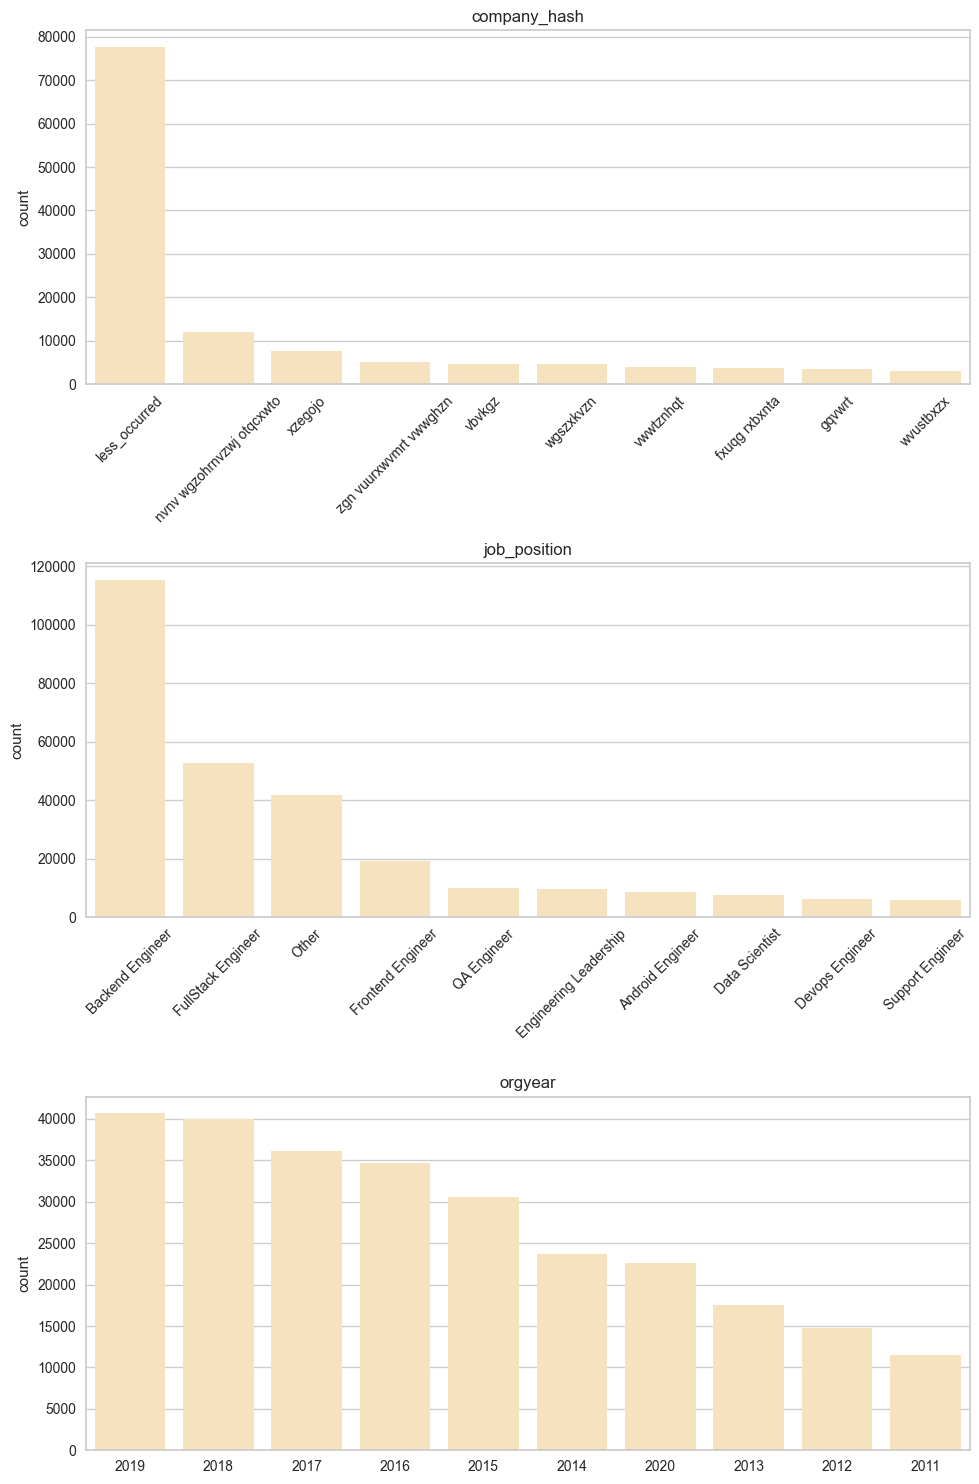

In [74]:
plt.figure(figsize=(10, 15))

i = 1
for col in obj_cols:
    # Get the top 10 values for the column
    top_10 = df_final[col].value_counts().nlargest(10)
    top_10_index = top_10.index

    ax = plt.subplot(3, 1, i)
    sns.countplot(x=df_final[col], order=top_10_index, color='moccasin')
    plt.title(f'{col}')
    if i <= 2:
        plt.xticks(rotation=45)

    ax.set_xlabel('')
    i += 1

plt.tight_layout()
plt.show()

Observations:
- We can easily find top 10 companies in terms of count in the dataset
- Top job position is 'Backend Engineer' followed by 'FullStack Engineer' and 'Others'
- Most of the employees started working in the year 2019 followed by 2018 and 2017

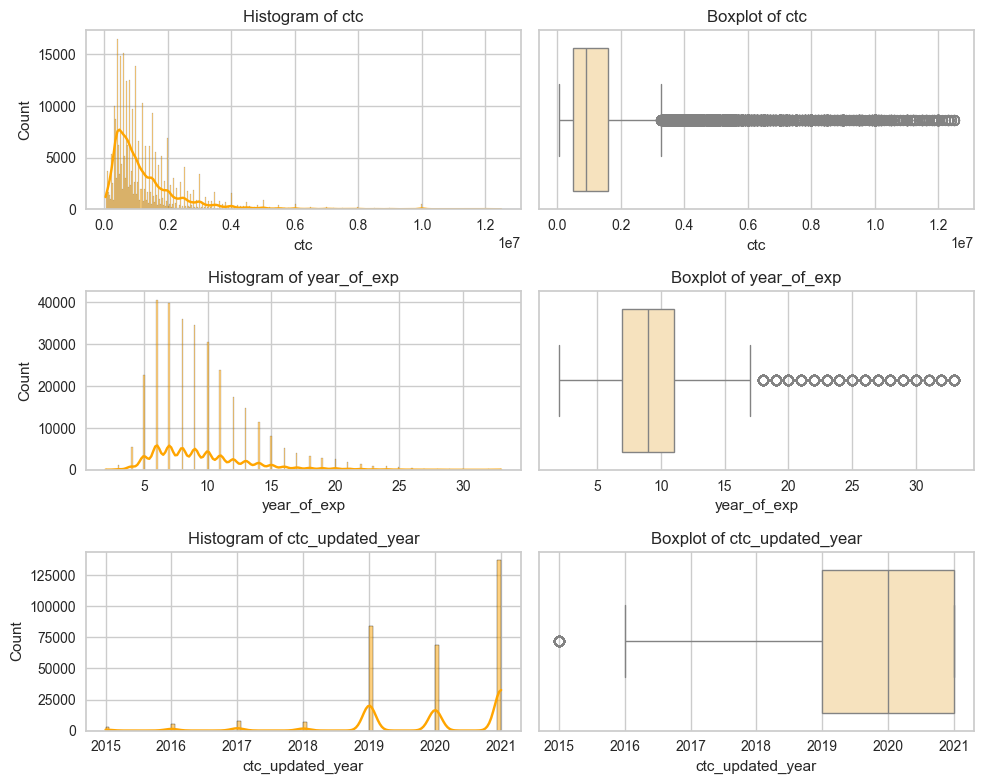

In [75]:
plt.figure(figsize=(10, 8))

# Loop through each numerical column and plot histogram and boxplot
for i, col in enumerate(num_cols):
    # Histogram
    ax1 = plt.subplot(3, 2, 2*i + 1)
    sns.histplot(df_final[col], kde=True, color='orange')
    plt.title(f'Histogram of {col}')

    # Boxplot
    ax2 = plt.subplot(3, 2, 2*i + 2)
    sns.boxplot(x=df_final[col], color='moccasin')
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

### 2. Bivariate Analysis

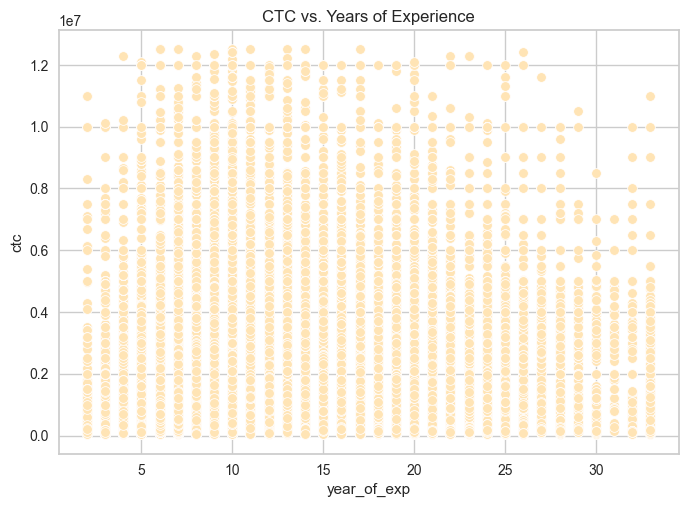

In [76]:
sns.scatterplot(x='year_of_exp', y='ctc', data=df_final, color='moccasin')
plt.title('CTC vs. Years of Experience')
plt.show()

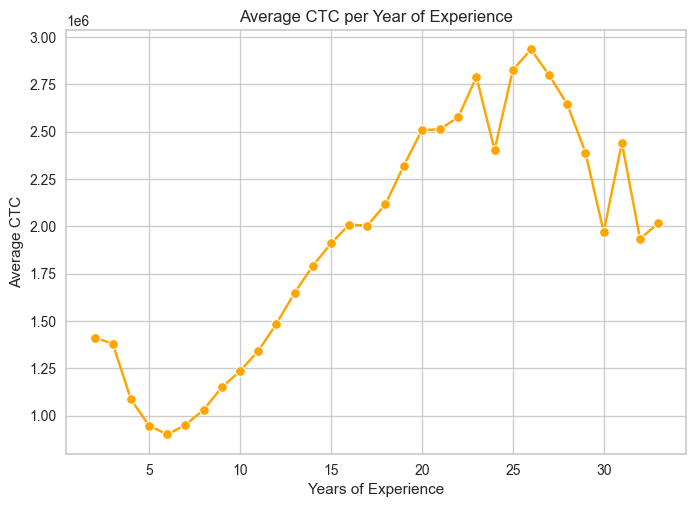

In [77]:
# Calculate average CTC per year of experience
avg_ctc_per_yoe = df_final.groupby('year_of_exp')['ctc'].mean().reset_index()

# Line plot with markers
sns.lineplot(x='year_of_exp', y='ctc', data=avg_ctc_per_yoe, marker='o', color='orange')
plt.title('Average CTC per Year of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Average CTC')

plt.show()
     

Observation:
- Average CTC is increasing after 5 years of experience till 22-23 years of experience
- After that there was a drop and increase and drop again. It's because of the age of the Employer where so many layoffs will happen which also leads to ctc dropped

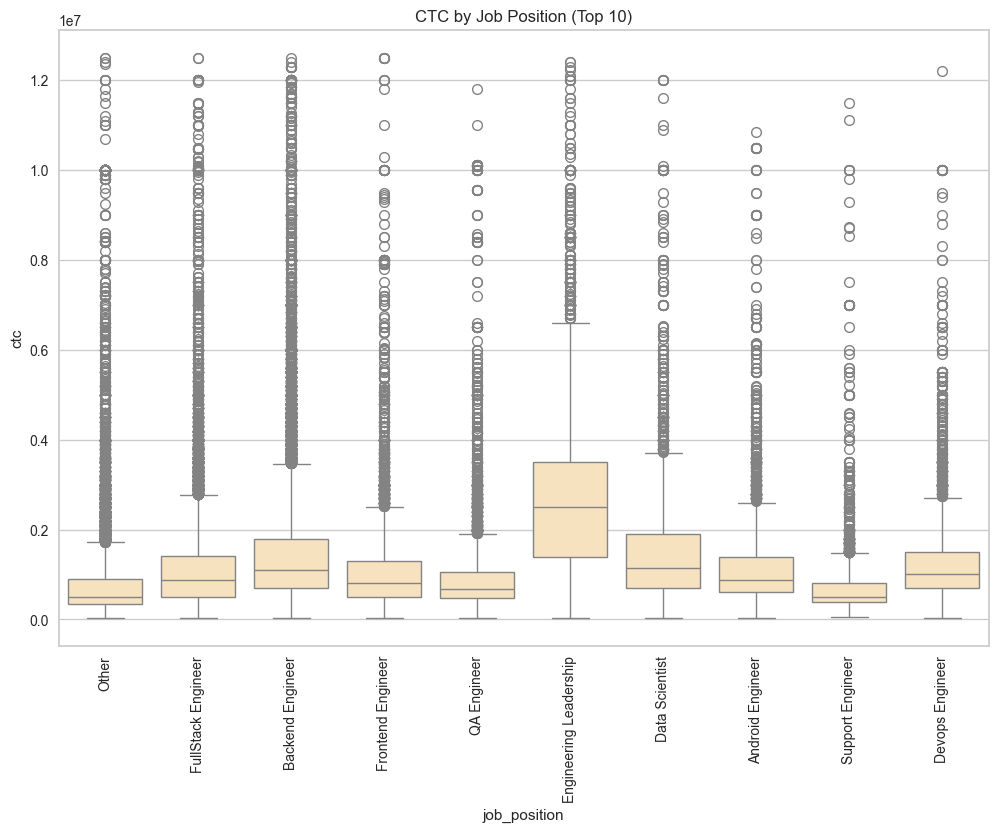

In [78]:
# Get the top 10 job positions by count
top_10_job_positions = df_final['job_position'].value_counts().nlargest(10).index

# Filter the dataset to include only the top 10 job positions
df_top_10 = df_final[df_final['job_position'].isin(top_10_job_positions)]
df_top_10["job_position"] = df_top_10['job_position'].astype('object')
# Plot the box plot for CTC by Job Position
plt.figure(figsize=(12, 8))
sns.boxplot(x='job_position', y='ctc', data=df_top_10, color='moccasin')
plt.xticks(rotation=90)
plt.title('CTC by Job Position (Top 10)')
plt.show()

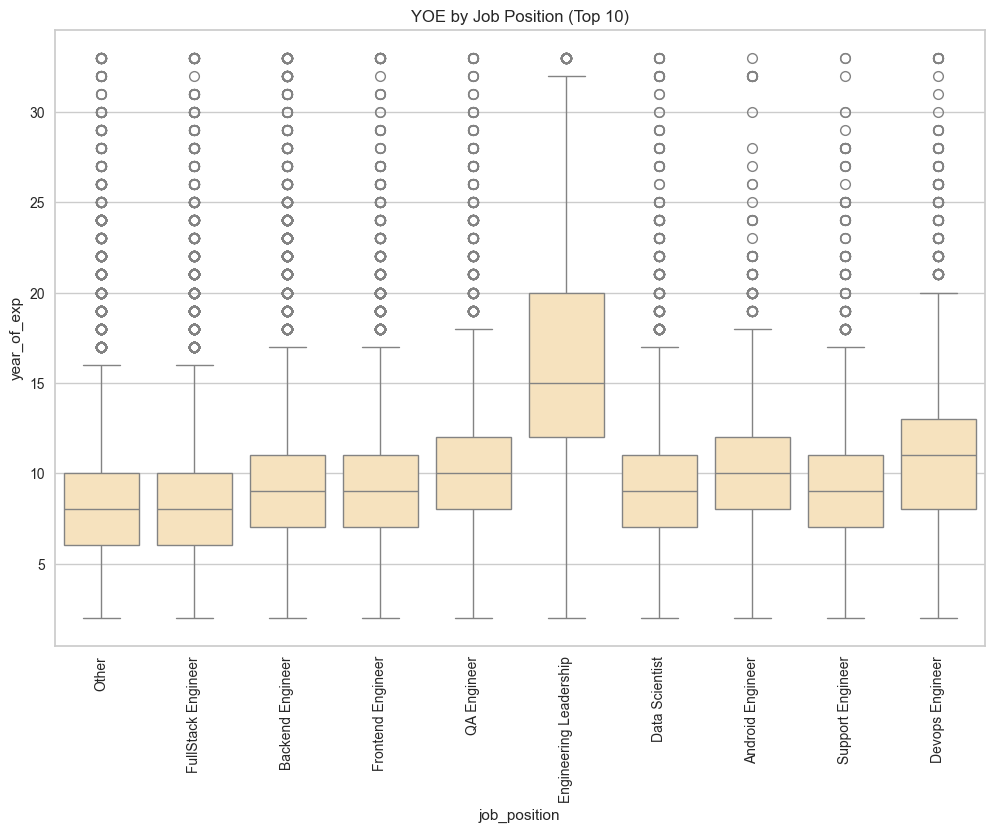

In [79]:
# Get the top 10 job positions by count
top_10_job_positions = df_final['job_position'].value_counts().nlargest(10).index

# Filter the dataset to include only the top 10 job positions
df_top_10 = df_final[df_final['job_position'].isin(top_10_job_positions)]
df_top_10["job_position"] = df_top_10['job_position'].astype('object')

# Plot the box plot for YOE by Job Position
plt.figure(figsize=(12, 8))
sns.boxplot(x='job_position', y='year_of_exp', data=df_top_10,color='moccasin')
plt.xticks(rotation=90)
plt.title('YOE by Job Position (Top 10)')
plt.show()

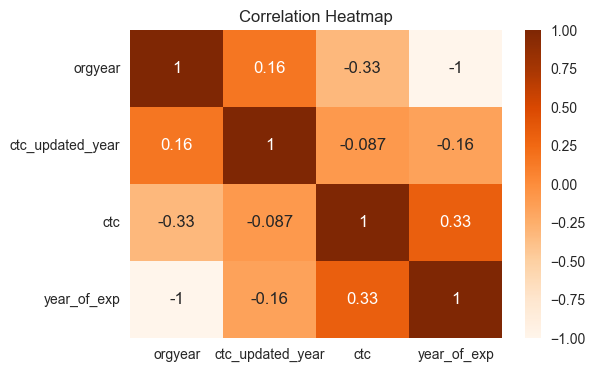

In [80]:
plt.figure(figsize=(6, 4))
sns.heatmap(df_final[['orgyear', 'ctc_updated_year', 'ctc', 'year_of_exp']].corr(), annot=True, cmap='Oranges')
plt.title('Correlation Heatmap')
plt.show()

Observation:
- orgyear and ctc_updated_year shown weak positive correlation
- Years of Experience and orgyear show strong negative correlation
- Years of Experience and CTC show weak positive correaltion

## Data Processing for Unsupervised Learning

In [81]:
email_hash_freq = df['email_hash'].value_counts().reset_index()
email_hash_freq.columns = ['email_hash', 'no_of_ctc_update']

new_df = pd.merge(df, email_hash_freq, on='email_hash', how='left')

In [82]:
new_df.drop(['email_hash', 'orgyear', 'ctc_updated_year'], axis=1, inplace=True)

In [83]:
df_cluster = new_df.copy()
new_df.head()

,company_hash,ctc,job_position,year_of_exp,no_of_ctc_update
0,atrgxnnt xzaxv,1100000,Other,9,2
1,qtrxvzwt xzegwgbb rxbxnta,449999,FullStack Engineer,7,2
2,less_occurred,2000000,Backend Engineer,10,2
3,ngpgutaxv,700000,Backend Engineer,8,1
4,qxen sqghu,1400000,FullStack Engineer,8,2


In [84]:
# Encoding non-numerical columns
# Frequency encoding for company_hash
company_hash_freq = new_df['company_hash'].value_counts().to_dict()
new_df['company_hash_encoded'] = new_df['company_hash'].map(company_hash_freq)

# Frequency encoding for job_position
job_position_freq = new_df['job_position'].value_counts().to_dict()
new_df['job_position_encoded'] = new_df['job_position'].map(job_position_freq)
     

In [85]:
new_df.drop(['company_hash', 'job_position'], axis=1, inplace=True)
new_df.head()

,ctc,year_of_exp,no_of_ctc_update,company_hash_encoded,job_position_encoded
0,1100000,9,2,9,26093
1,449999,7,2,421,30900
2,2000000,10,2,46556,70968
3,700000,8,1,70,70968
4,1400000,8,2,6,30900


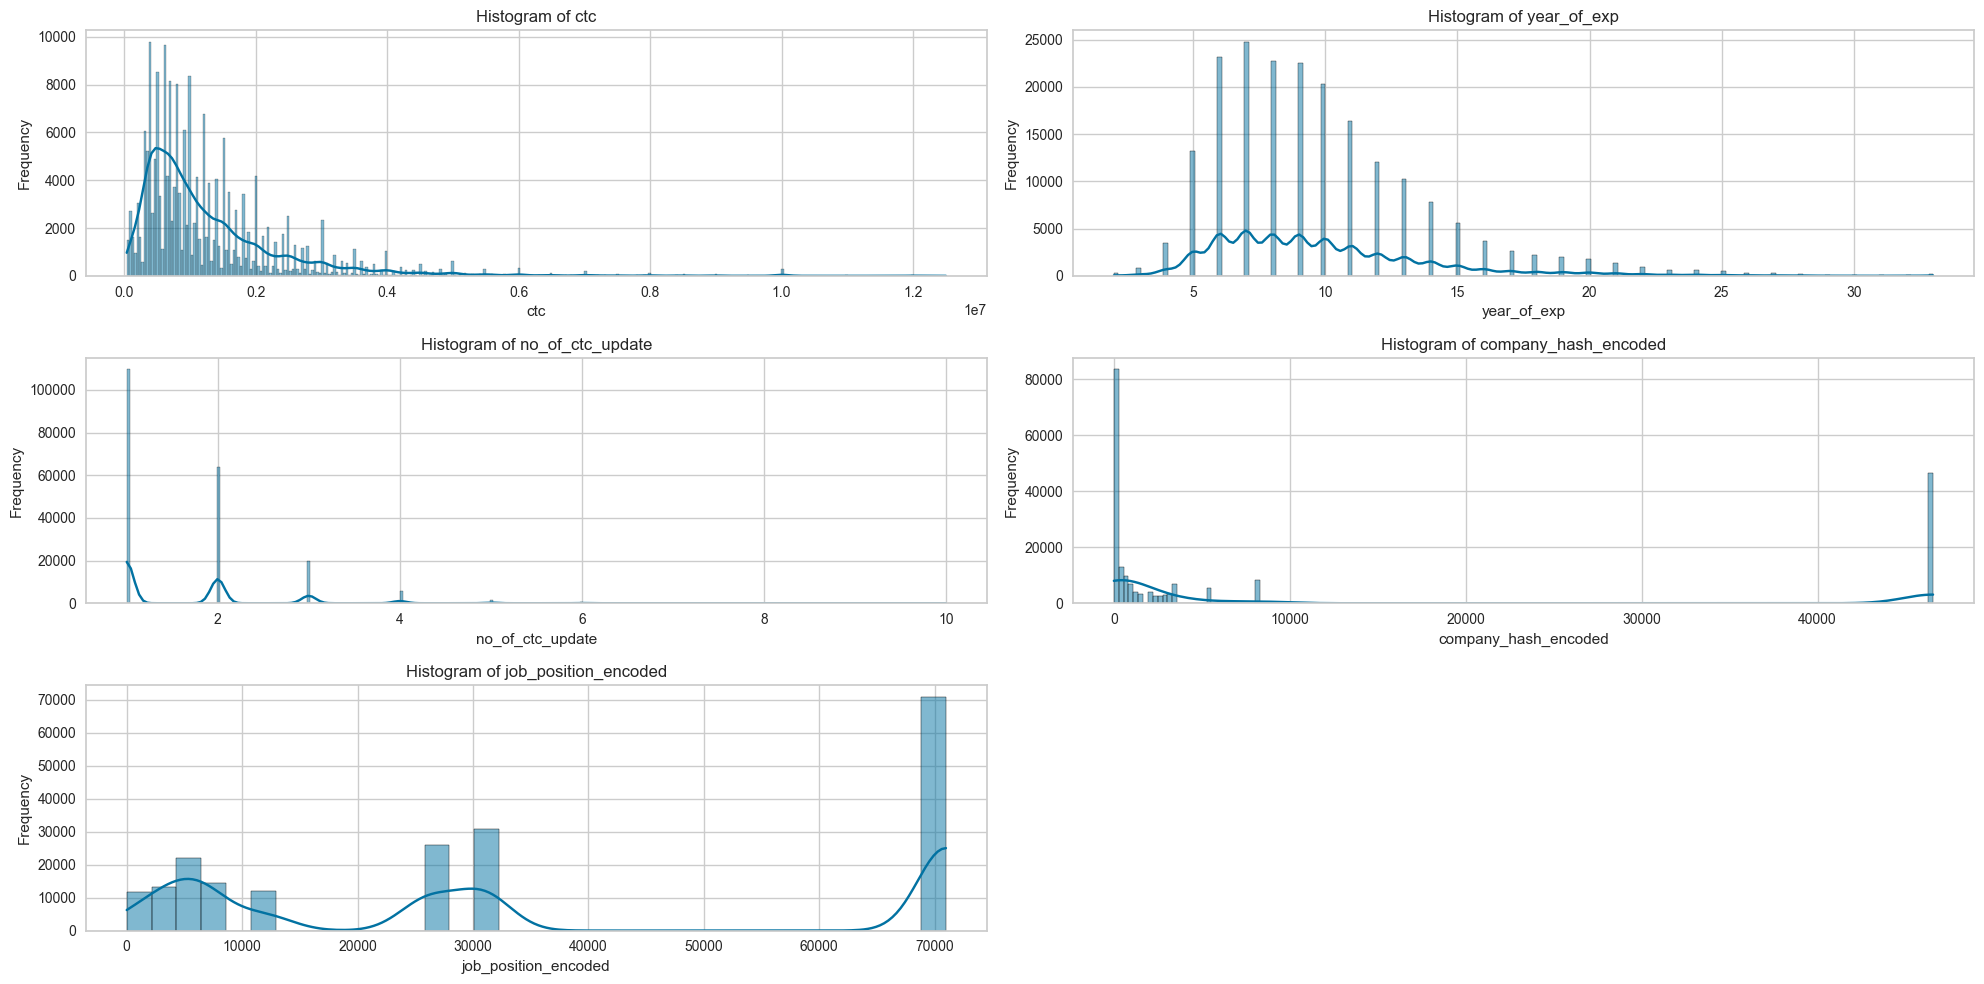

In [86]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))  
axes = axes.flatten()  

# Plot each column
for i, col in enumerate(new_df.columns):
    sns.histplot(new_df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide the unused subplot
if len(new_df.columns) < len(axes):
    for j in range(len(new_df.columns), len(axes)):
        axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [87]:
new_df['ctc_log'] = np.log1p(new_df['ctc'])

In [88]:
new_df = new_df.drop(['ctc'], axis=1)

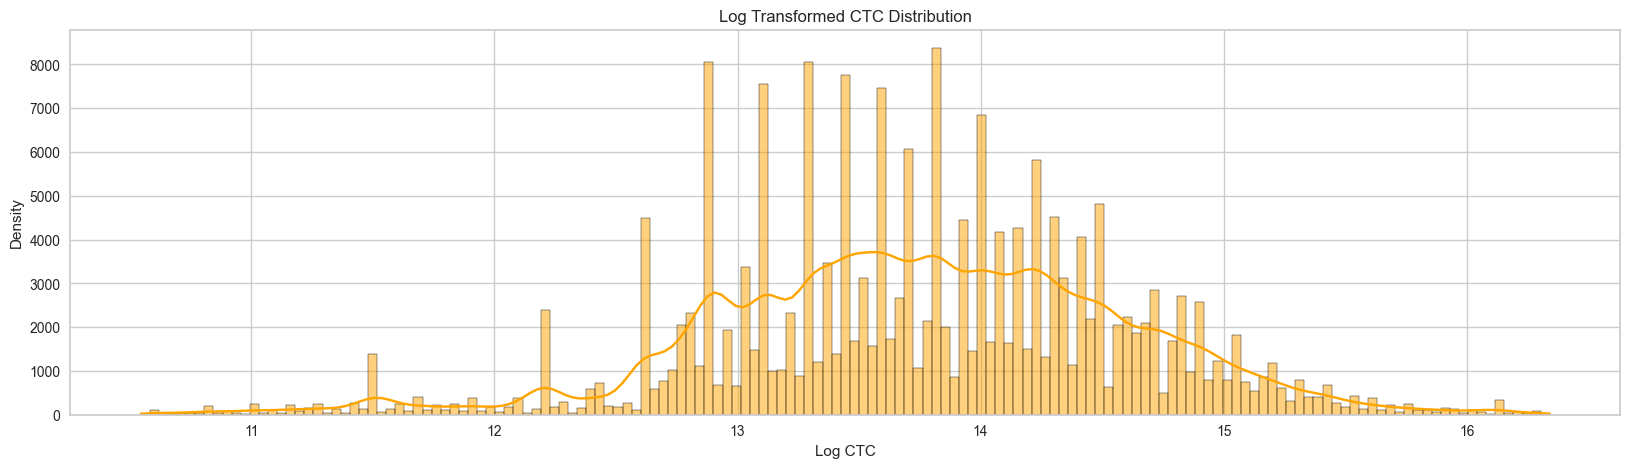

In [89]:
# histogram of log transformed ctc
plt.figure(figsize=(20, 5))
sns.histplot(new_df['ctc_log'], kde=True, color='orange')
plt.title('Log Transformed CTC Distribution')
plt.xlabel('Log CTC')
plt.ylabel('Density')
plt.show()


In [90]:
# Standard Scaling
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
scaled_features = scaler.fit_transform(new_df[['year_of_exp', 'no_of_ctc_update', 'company_hash_encoded', 'job_position_encoded', 'ctc_log']])

# Convert the scaled features back to a DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=['year_of_exp', 'no_of_ctc_update', 'company_hash_encoded', 'job_position_encoded', 'ctc_log'])

In [91]:
df_scaled.head()

,year_of_exp,no_of_ctc_update,company_hash_encoded,job_position_encoded,ctc_log
0,-0.208826,0.392346,-0.609758,-0.326032,0.192686
1,-0.684528,0.392346,-0.588279,-0.154286,-0.858981
2,0.029025,0.392346,1.816821,1.277282,0.896100
3,-0.446677,-0.736985,-0.606577,1.277282,-0.339119
4,-0.446677,0.392346,-0.609914,-0.154286,0.476437


## Model Building

In [92]:
def hopkins_statistic(X):
    X = np.array(X)  # Ensure X is a numpy array
    d = X.shape[1]  # Number of dimensions
    n = len(X)  # Number of data points
    m = int(0.1 * n)  # Subset size (10% of the data points)

    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    rand_X = np.random.random((m, d)) * np.amax(X, axis=0)
    u_distances, _ = nbrs.kneighbors(rand_X, 2, return_distance=True)

    w_distances, _ = nbrs.kneighbors(X[np.random.choice(n, m, replace=False)], 2, return_distance=True)

    u_distances = u_distances[:, 1]
    w_distances = w_distances[:, 1]

    H = (np.sum(u_distances) / (np.sum(u_distances) + np.sum(w_distances)))
    return H

hopkins_score = hopkins_statistic(df_scaled)
print(f"Hopkins Statistic: {hopkins_score}")

Hopkins Statistic: 0.9921965917121176


Observation:
- The value is very close to 1, which means that the dataset has a very strong clustering structure. It is likely to form well defined clusters

Elbow Method- To select optimal number of clusters

Inertia

Within Cluster Sum of Squares. This metric measures how tightly the clusters are packed. Lower inertia values indicate better-defined clusters.

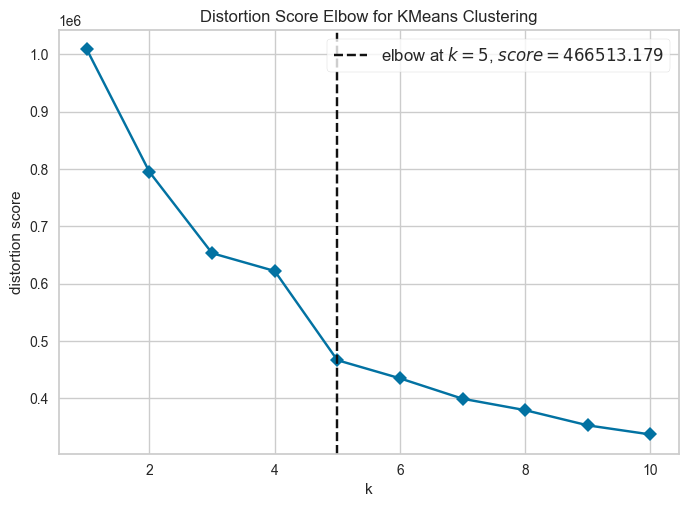

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [93]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(df_scaled)       # Fit data to visualizer
visualizer.show()      

Observation:
- The elbow point suggests that 5 clusters is a good choice for our data. This is where the inertia starts to decrease at a slower rate, indicating that additional clusters beyond this point don't significantly improve the clustering quality.

In [94]:
new_df.head()

,year_of_exp,no_of_ctc_update,company_hash_encoded,job_position_encoded,ctc_log
0,9,2,9,26093,13.910822
1,7,2,421,30900,13.017003
2,10,2,46556,70968,14.508658
3,8,1,70,70968,13.458837
4,8,2,6,30900,14.151984


In [95]:
optimal_clusters = 5  # Set the optimal number of clusters as found above
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(df_scaled)

# Adding cluster labels to the DataFrame
df_cluster['kmeans_cluster'] = kmeans.labels_

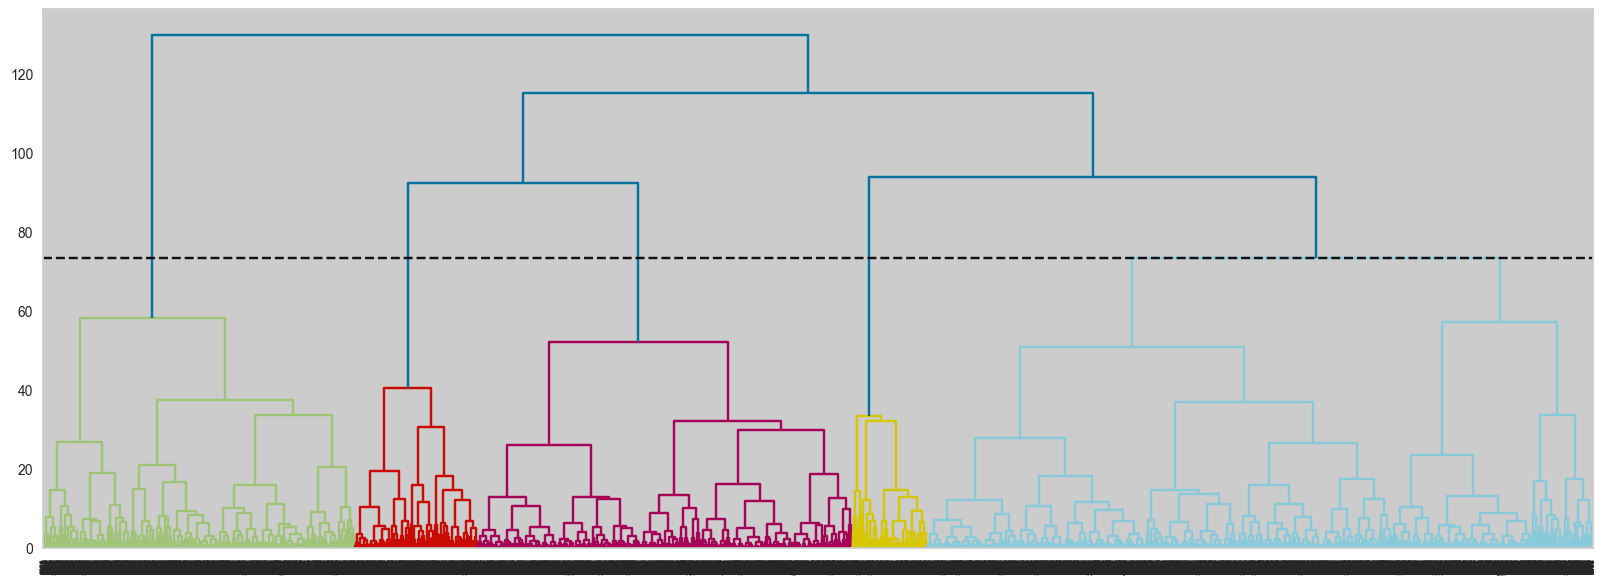

In [96]:
# Sample a subset of the data
df_sampled = df_scaled.sample(n=10000, random_state=0)

# Perform hierarchical clustering
Z = linkage(df_sampled, method='ward')

# Get cluster assignments for 5 clusters
cluster_labels = fcluster(Z, t=5, criterion='maxclust')

# Then plot with color_threshold that matches this cut
plt.figure(figsize=(20, 7))
dendrogram(Z, color_threshold=Z[-5, 2]+0.5)  # Cut at the height that gives 5 clusters
plt.axhline(Z[-5, 2], c='k', linestyle='--')  # Optional: show cut line
plt.show()

Observations:
- Used Representative subset of data to avoid running out of memory.
- Dendogram is showing 5 different colored branches at the end representing 5 clusters

In [97]:
# Within-Cluster Sum of Squares (WCSS)
wcss = kmeans.inertia_
print(f'Within-Cluster Sum of Squares (WCSS): {wcss}')

Within-Cluster Sum of Squares (WCSS): 466513.1994304687


Observation:
- The elbow method helps identify the optimal number of clusters by plotting WCSS values for different 𝑘 values and looking for a point where the decrease in WCSS slows down.
- If 𝑘=5 is identified as the elbow point, it suggests that adding more clusters beyond this number does not significantly reduce the WCSS, indicating diminishing returns in terms of cluster compactness.

In [98]:
# Between-Cluster Sum of Squares (BCSS)
# Assuming df_scaled is your scaled dataframe
df_scaled_copy = df_scaled.copy()

# Adding cluster labels to the DataFrame
df_scaled_copy['kmeans_cluster'] = kmeans.labels_

# Between-Cluster Sum of Squares (BCSS)
def calculate_bcss(df, kmeans):
    cluster_centers = kmeans.cluster_centers_
    overall_mean = df.drop(columns='kmeans_cluster').mean(axis=0)
    bcss = 0
    for i, center in enumerate(cluster_centers):
        size = len(df[df['kmeans_cluster'] == i])
        bcss += size * np.sum((center - overall_mean) ** 2)
    return bcss

bcss = calculate_bcss(df_scaled_copy, kmeans)
print(f'Between-Cluster Sum of Squares (BCSS): {bcss}')

Between-Cluster Sum of Squares (BCSS): 541522.180778658


Observation:
- High BCSS and Low WCSS: The combination of a relatively high BCSS and a relatively low WCSS is desirable. It means that the clusters are well-separated and compact.

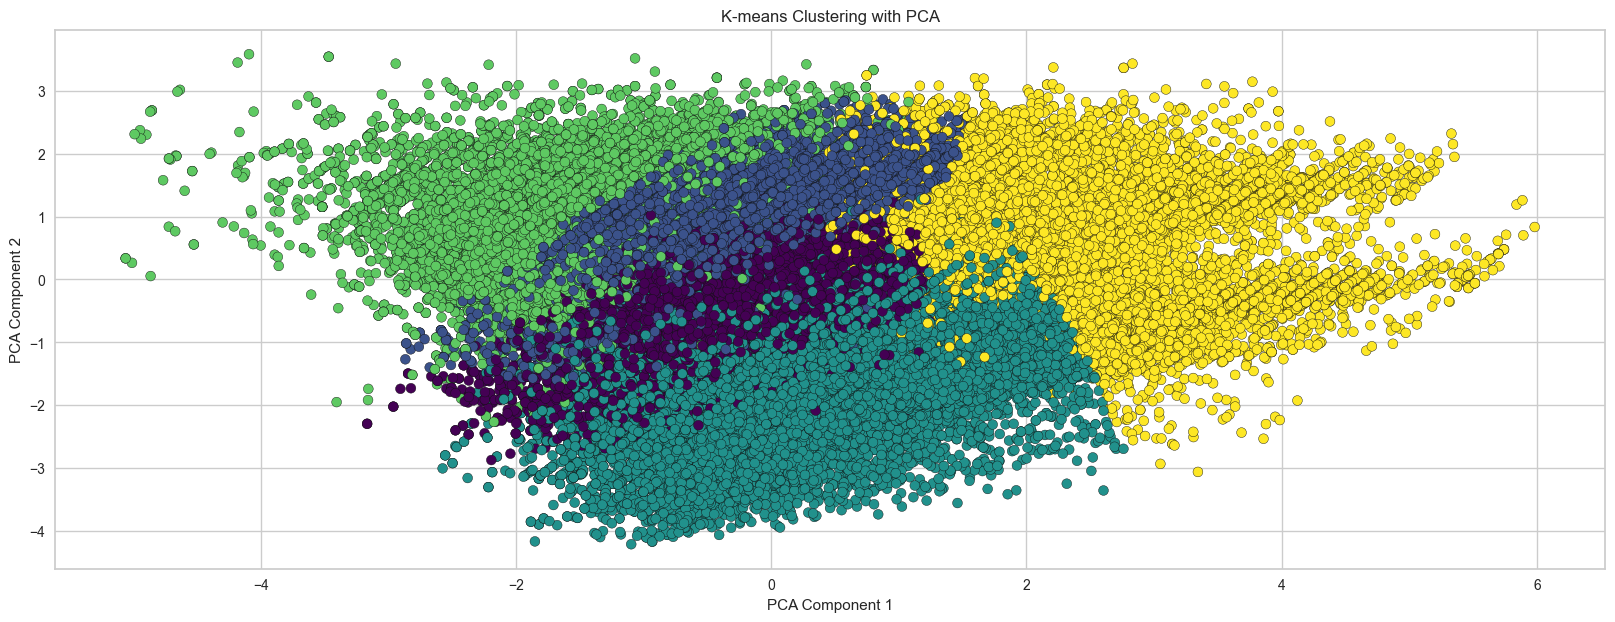

In [99]:
#Visual Inspection using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled_copy.drop(columns='kmeans_cluster'))

df_scaled_copy['pca_one'] = pca_result[:, 0]
df_scaled_copy['pca_two'] = pca_result[:, 1]

plt.figure(figsize=(20, 7))
plt.scatter(df_scaled_copy['pca_one'], df_scaled_copy['pca_two'], c=df_scaled_copy['kmeans_cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('K-means Clustering with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [100]:
cluster_sizes = df_cluster['kmeans_cluster'].value_counts().sort_index()
print(f'Cluster Sizes:\n{cluster_sizes}')

Cluster Sizes:
kmeans_cluster
0    63761
1    47673
2    42068
3    24164
4    23975
Name: count, dtype: int64


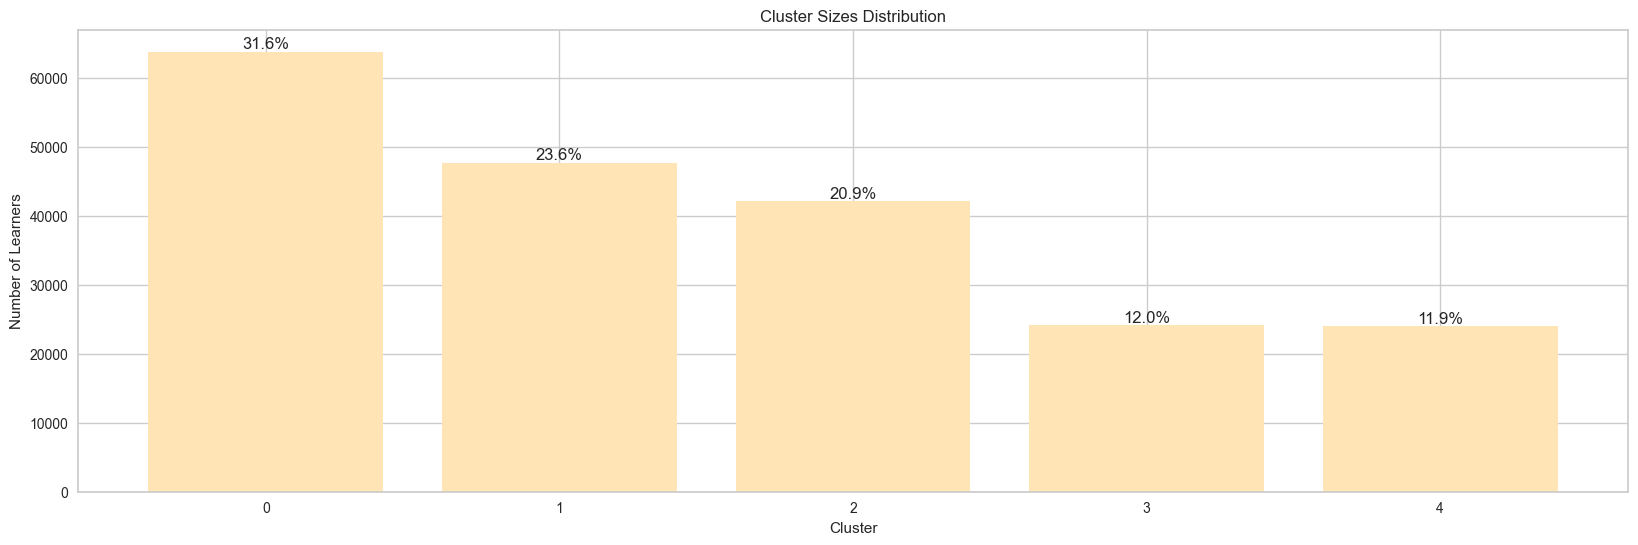

In [101]:
# Assuming cluster sizes are stored in a dictionary
cluster_sizes = {0: 63761, 1: 47673, 2: 42068, 3: 24164, 4: 23975}

# Calculate the total number of learners
total_learners = sum(cluster_sizes.values())

# Create a bar chart
plt.figure(figsize=(20, 6))
bars = plt.bar(cluster_sizes.keys(), cluster_sizes.values(), color='moccasin')

# Add percentage labels above the bars
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_learners) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Cluster')
plt.ylabel('Number of Learners')
plt.title('Cluster Sizes Distribution')
plt.show()

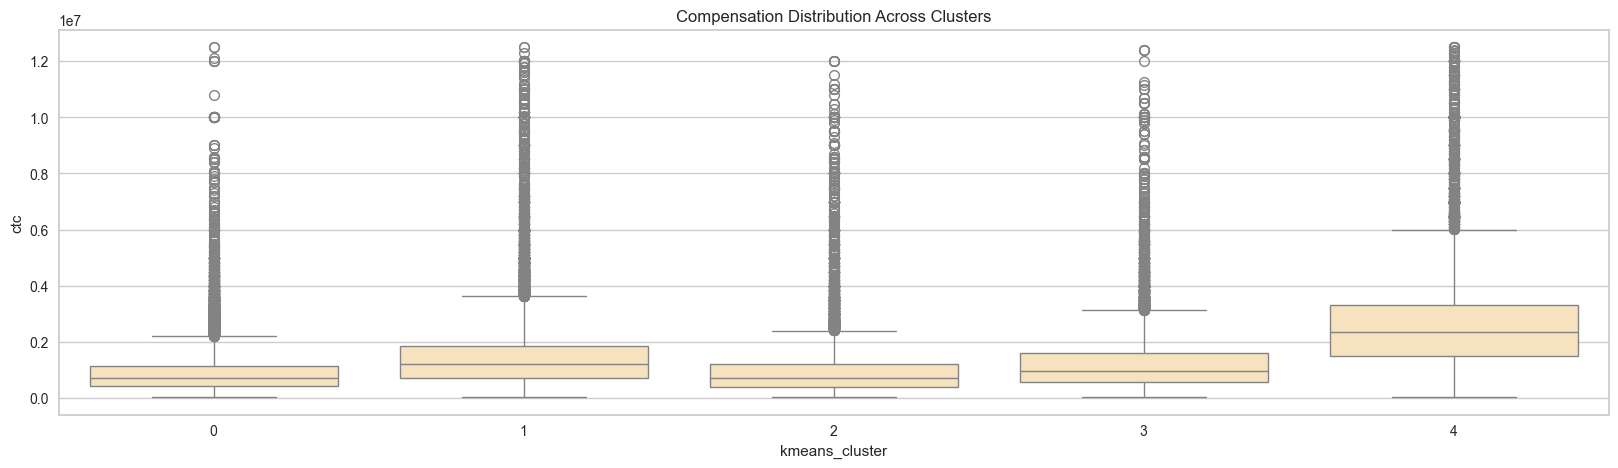

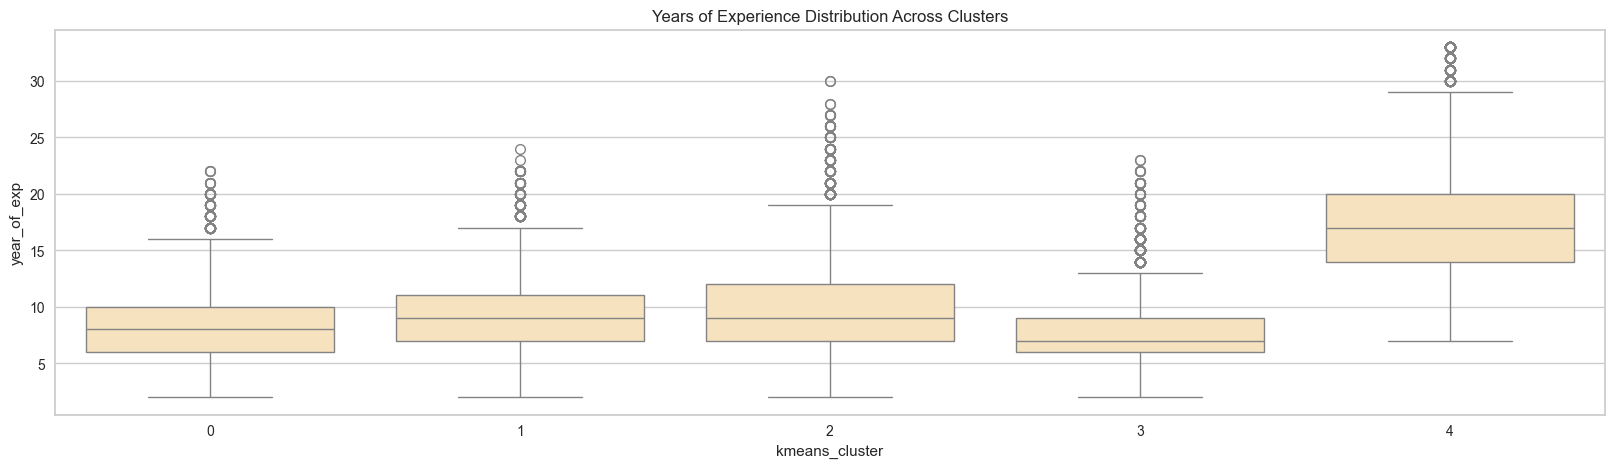

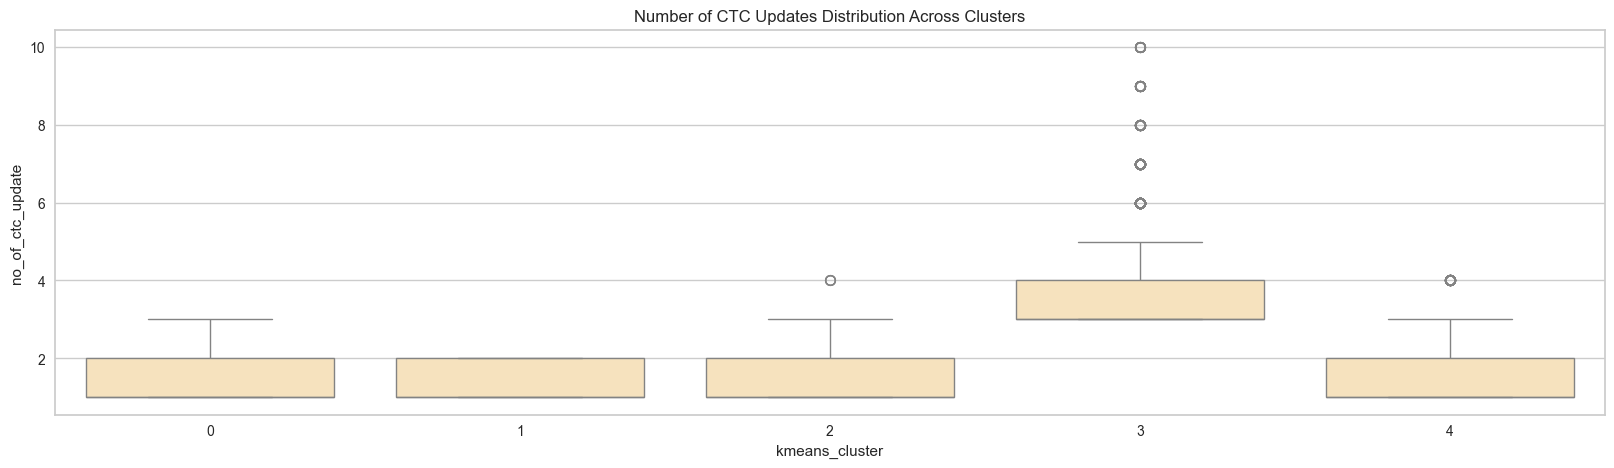

In [102]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='kmeans_cluster', y='ctc', data=df_cluster,color='moccasin')
plt.title('Compensation Distribution Across Clusters')
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(x='kmeans_cluster', y='year_of_exp', data=df_cluster,color='moccasin')
plt.title('Years of Experience Distribution Across Clusters')
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(x='kmeans_cluster', y='no_of_ctc_update', data=df_cluster, color='moccasin')
plt.title('Number of CTC Updates Distribution Across Clusters')
plt.show()

Observation: 
- Compensation is high for cluster 4 followed by cluster 1
- Years of Experience is highest for cluster 4 followed by 2 and 1
- CTC_updates is high for cluster 3
- Compensation and Years of Exp is relatively higher for cluster 4

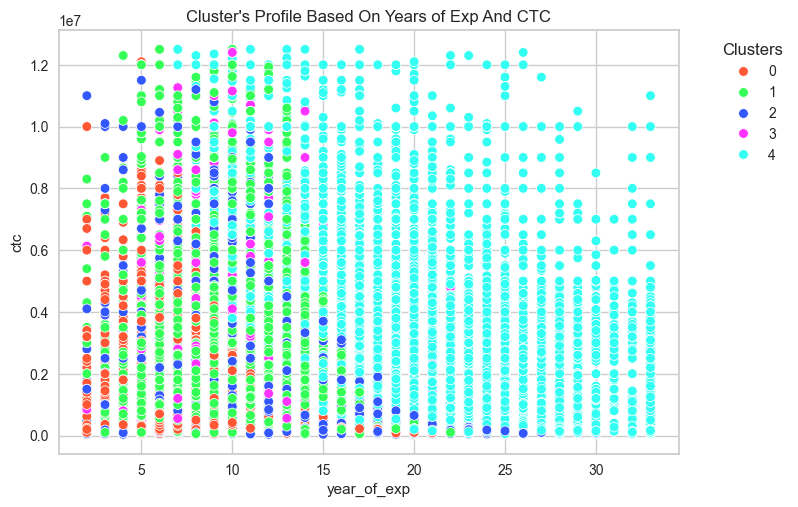

In [103]:
# Define a custom color palette with distinct colors
custom_palette = sns.color_palette(["#FF5733", "#33FF57", "#3357FF", "#FF33FF", "#33FFF3"])

# Create the scatter plot with the custom palette
pl = sns.scatterplot(data=df_cluster, x="year_of_exp", y="ctc", hue="kmeans_cluster", palette=custom_palette)

# Set the title
pl.set_title("Cluster's Profile Based On Years of Exp And CTC")

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Clusters')

# Show the plot
plt.show()

Observation:
- Cluster 4 has relatively higher years of experience and compensation which was reflected from above box plots too
- Cluster 1 has lesser years of experience and w.r.t cluster 4 and most of the compensation is lower

In [104]:
# Select only numeric columns for aggregation
numeric_columns = ['ctc', 'year_of_exp', 'no_of_ctc_update']

# Calculate mean values for each cluster
cluster_averages = df_cluster.groupby('kmeans_cluster')[numeric_columns].mean()

# Display the average values for each cluste
print(cluster_averages)
     

                         ctc  year_of_exp  no_of_ctc_update
kmeans_cluster                                             
0               9.264998e+05     8.306739          1.416242
1               1.470352e+06     9.192016          1.414952
2               9.442261e+05     9.722093          1.402420
3               1.284018e+06     8.083761          3.476784
4               2.704498e+06    17.502482          1.354035


In [105]:
# Function to get the most common job positions and companies in each cluster
def get_common_entries(df, cluster_label, column_name, top_n=3):
    cluster_data = df[df['kmeans_cluster'] == cluster_label]
    most_common_entries = Counter(cluster_data[column_name]).most_common(top_n)
    return most_common_entries

# Get profiles for each cluster
cluster_profiles = {}

for cluster in range(5):
    job_positions = get_common_entries(df_cluster, cluster, 'job_position')
    companies = get_common_entries(df_cluster, cluster, 'company_hash')

    cluster_profiles[cluster] = {
        'average_ctc': cluster_averages.loc[cluster, 'ctc'],
        'average_yoe': cluster_averages.loc[cluster, 'year_of_exp'],
        'average_ctc_updates': cluster_averages.loc[cluster, 'no_of_ctc_update'],
        'common_job_positions': job_positions,
        'common_companies': companies
    }

# Display the profiles
for cluster, profile in cluster_profiles.items():
    print(f"Cluster {cluster}:")
    print(f"  Average Compensation (CTC): {profile['average_ctc']}")
    print(f"  Average Years of Experience: {profile['average_yoe']} years")
    print(f"  Average Number of CTC Updates: {profile['average_ctc_updates']}")
    print("  Common Job Positions:")
    for job, count in profile['common_job_positions']:
        print(f"    - {job}: {count} occurrences")
    print("  Common Companies:")
    for company, count in profile['common_companies']:
        print(f"    - {company}: {count} occurrences")
    print()

Cluster 0:
  Average Compensation (CTC): 926499.79399633
  Average Years of Experience: 8.306739229309452 years
  Average Number of CTC Updates: 1.416241903357852
  Common Job Positions:
    - FullStack Engineer: 16378 occurrences
    - Other: 15831 occurrences
    - Frontend Engineer: 5792 occurrences
  Common Companies:
    - nvnv wgzohrnvzwj otqcxwto: 3790 occurrences
    - xzegojo: 3080 occurrences
    - zgn vuurxwvmrt vwwghzn: 1933 occurrences

Cluster 1:
  Average Compensation (CTC): 1470351.6018920564
  Average Years of Experience: 9.192016445367399 years
  Average Number of CTC Updates: 1.4149518595431376
  Common Job Positions:
    - Backend Engineer: 47535 occurrences
    - FullStack Engineer: 120 occurrences
    - Other: 18 occurrences
  Common Companies:
    - nvnv wgzohrnvzwj otqcxwto: 2373 occurrences
    - vbvkgz: 1424 occurrences
    - xzegojo: 1046 occurrences

Cluster 2:
  Average Compensation (CTC): 944226.1393458211
  Average Years of Experience: 9.722092802129884 y

Observations:

Cluster 0:
- Average CTC: ~₹9.26L
- Experience: ~8.3 years
- CTC Updates: ~1.4
- Common Roles: FullStack, Other, Frontend
- This cluster represents mid-career engineers with moderately high compensation. The presence of FullStack and Frontend roles suggests they are versatile in development, likely working in product or startup environments. The variety in job titles indicates some role fluidity.

Cluster 1:
- Average CTC: ~₹14.7L
- Experience: ~9.2 years
- CTC Updates: ~1.41
- Common Roles: Backend Engineer dominates
- Despite having only slightly more experience than Cluster 0, these professionals earn significantly higher compensation, likely due to specialization in Backend Engineering. The narrow job distribution suggests domain expertise and higher demand for backend roles in certain companies.

Cluster 2:
- Average CTC: ~₹9.44L
- Experience: ~9.7 years
- CTC Updates: ~1.4
- Common Roles: Mixed (Backend, FullStack, Other)
- This group is experienced but with modest compensation, possibly indicating a broad but non-specialized skill set. The high occurrence of “less_occurred” companies hints they might be employed in smaller or lesser-known firms, or there's some data masking/generalization.

Cluster 3:
- Average CTC: ~₹12.84L
- Experience: ~8.1 years
- CTC Updates: 3.47 (notably high)
- Common Roles: Backend and FullStack
- The standout feature here is the high number of CTC updates, suggesting a group that is either actively negotiating, switching jobs, or being promoted frequently. Their compensation is fairly high, and they likely work in dynamic or competitive environments.

Cluster 4:
- Average CTC: ~₹27.04L
- Experience: ~17.5 years
- CTC Updates: ~1.35
- Common Roles: Engineering Leadership dominates
- This cluster clearly consists of senior-level professionals or executives. Extremely high compensation and extensive experience point to leadership positions in engineering, possibly VPs, Directors, or Engineering Managers. They're typically in established firms, as seen by more structured job titles.

Insights:
--------------
Clusters 0 & 1: Both are mid-level engineers, but Cluster 1 benefits from specialization (Backend) which boosts compensation.

Cluster 2: More experienced but undercompensated, perhaps due to company type or non-core roles.

Cluster 3: Similar in experience to Cluster 0 but unusually high job/CTC mobility, possibly agile performers or job switchers.

Cluster 4: Clearly senior leadership, with matching experience and high pay.